In [1]:
import os

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import datetime as dt
import math
from datetime import datetime

# Introduction

Make river input scenarios for OF800

# User input

In [4]:
# Version number
v = 2  # For file naming

# Filepath to baseline daily river data
fpath_baseline_data = r"/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/martini_rivers_v9_1990_2022_stage1data.nc"

# Filepath to river metadata csvs
real_riv_metadata = r"../../data/real_river_metadata.csv"
riv_no_mapping_fpath = r"../../data/oslofjord_location_ids.csv"

# TEOTIL results (annual source apportionment)
# Baseline data
teotil_res_csv_fpath = (
    r"/home/jovyan/shared/common/teotil3/evaluation/teo3_results_nve2024_2013-2023_agri-annual-loss.csv"
)
# WWTW scenario data
pc_reduction = 80  # 80 or 85% (80% was the most up-to-date estimate of what would be in the new WWTD in April 2024)
teotil_scen_res_folder = f"/home/jovyan/shared/common/oslofjord_modelling/wastewater_scenarios/scen_totn_{pc_reduction}pct_effect"
teotil_scen_res_fname = "teo3_scenario_results_nve2023_2013-2022.csv"
teotil_scen_res_fpath = os.path.join(teotil_scen_res_folder, teotil_scen_res_fname)

# # Scenarios info
# scenario_setup_fpath = r"../data/md_of800_scenarios.csv"

# Start and end year to summarise TEOTIL data over
start_year = 2013  # 2016
end_year = 2022

# Folders for output files
netcdf_outfolder = r"/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/river_scenarios"
csv_exploration_folder = r"../../output/csvs"
fig_folder = r"../../output/plots"

# REAL river numbers to use
# full OF800 domain: model rivs 4-29 incl. Drop Sweden, becomes 7 to 29 (incl.)
oslofjord_riv_nos = range(6, 24)  # Whole OF domain, excluding 2 Swedish rivers
print(f"Generating scenarios for real rivers:\n{list(oslofjord_riv_nos)}")

# species of interest  # only din works now
par = 'din'

Generating scenarios for real rivers:
[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


# Set up & read in river metadata

In [5]:
if par in ['din', 'ton', 'totn']:
    species = 'N'
elif par in ['tdp', 'tpp', 'totp']:
    species = 'P'

riv_var_li_dict = {
    "N": [
        "river_NH4N",
        "river_NO3NO2N",
        "river_TOTN",
        "river_DON",
        "river_PON",
        "river_transport",
    ],
    "P": [
        "river_SRP",
        "river_TOTP",
        "river_DOP",
        "river_POP",
        "river_TIP",
        "river_transport",
    ],
}

derived_chemvar_dict = {
    "N": ['din', 'ton'],
    "P": ['tdp']
}

riv_var_li = riv_var_li_dict[species]
chem_var_li = riv_var_li.copy() + derived_chemvar_dict[species]
chem_var_li.remove('river_transport')

# Calculate start date (inclusive), end date (day after last day)
start_date = dt.datetime(start_year, 1, 1)
end_date = dt.datetime(end_year, 12, 31)
end_date += pd.Timedelta(days=1)

# River chemistry metadata
river_meta_df = pd.read_csv(real_riv_metadata, index_col=0, dtype={'Vassom':str})
# Limit to just Oslofjord rivers
river_meta_df = river_meta_df[river_meta_df.index.isin(oslofjord_riv_nos)]
# Add 'total' row for use later
river_meta_df.loc['Total', ['river_name', 'Regine', 'Regine_to_sea', 'Vassom']] = 'Total'
river_meta_df.query('real_river in @oslofjord_riv_nos')

river_name  Outflow_lat  Outflow_lon   Regine Regine_to_sea  \
real_river                                                                    
6                    Tista       59.119       11.370   001.A1        001.A1   
7                   Glomma       59.206       10.953  002.A51       002.A11   
8                Mosseelva       59.439       10.662   003.A1        003.A1   
9                Hølenelva       59.523       10.690   004.A0        004.A0   
10                Årungen        59.720       10.728   005.3A        005.3A   
11               Akerselva       59.908       10.756  006.A10       006.A10   
12             Lysakerelva       59.914       10.640   007.A0        007.A0   
13            Sandvikselva       59.890       10.523  008.A11       008.A11   
14                    Åros       59.704       10.519   009.A0        009.A0   
15               Tofteelva       59.547       10.568   010.2Z        010.2Z   
16              Sageneelva       59.533       10.530   010.3A        010.3A   
17                Lierelva       59.751       10.285   011.A0        011.A0   
18            Drammenselva       59.732       10.235   012.A3       012.A10   
19               Sandeelva       59.572       10.243   013.A0        013.A0   
20                Aulielva       59.278       10.379   014.A0        014.A0   
21           Numedalslågen       59.047       10.068   015.A1        015.A1   
22              Skienselva       59.135        9.629  016.A11       016.A11   
23          Kammerfosselva       58.867        9.354   017.A1        017.A1   

           Vassom  Vassom_area_land  Vassom_area_tot  Andre_MCA_area  \
real_river                                                             
6            001.            2495.0           2507.0          2507.0   
7            002.           42446.0          43116.0         43116.0   
8            003.             854.0           1052.0          1054.0   
9            004.             204.0            227.0             NaN   
10           005.             280.0            368.0           144.0   
11           006.             392.0            415.0           415.0   
12           007.             202.0            211.0           211.0   
13           008.             279.0            311.0           311.0   
14           009.             215.0            253.0             NaN   
15           010.             114.0            191.0             NaN   
16           010.             114.0            191.0             NaN   
17           011.             360.0            396.0             NaN   
18           012.           17180.0          17209.0         17209.0   
19           013.             365.0            546.0             NaN   
20           014.             595.0           1114.0             NaN   
21           015.            6275.0           6515.0          6515.0   
22           016.           11279.0          11384.0         11384.0   
23           017.            1580.0           1821.0          1821.0   

            Andre_area_q  Overestimate (%)  \
real_river                                   
6                 1584.0               0.0   
7                41967.0               2.0   
8                  694.0              23.0   
9                    NaN              11.0   
10                  85.0              31.0   
11                 307.0               6.0   
12                 177.0               4.0   
13                 226.0              11.0   
14                   NaN              18.0   
15                   NaN              68.0   
16                   NaN              68.0   
17                   NaN              10.0   
18               17108.0               0.0   
19                   NaN              50.0   
20                   NaN              87.0   
21                5548.0               4.0   
22               10808.0               1.0   
23                1238.0              15.0   

                                                      Comment  
real_rive

# TEOTIL source apportionment

## Read in data

In [6]:
def extract_source(col_name):
    """
    Function to rename teotil columns
    """
    parts = col_name.split('_')
    return parts[1]


def read_teotil_data(teotil_data_fpath):
    """
    Function to read raw TEOTIL data, pick the columns of interest (just accumulated inputs
    from all upstream areas), rename columns, truncate to the period of interest.

    Do this for both areas upstream of a given regine of interest, or whole vassdragsområder
    """
    df = pd.read_csv(teotil_data_fpath)

    # Just pick out accumulated inputs (from all upstream areas)
    # for the outflow reginer of interest
    cols = ["regine", "year"] + [
        col for col in df.columns if f"_{par}_" in col and col.startswith("accum")
    ]
    df = df.loc[df['regine'].isin(river_meta_df['Regine'])][cols]

    # Truncate to start of model period onwards (currently to 2022)
    df = df.loc[df['year'] >= start_year]

    # Rename columns
    cols_to_exclude = ['regine', 'year']
    new_col_names = {col: extract_source(col) for col in df.columns if col not in cols_to_exclude}
    new_col_names = cols_to_exclude + list(new_col_names.values())
    col_dict = dict(zip(df.columns, new_col_names))
    df = df.rename(columns=col_dict)

    return df


def teotil_average_over_years(res_df):
    """
    Average over all years to get a single value per main catchment area (or real river).
    Replace 'regine' index with river numbers
    """

    # Average over the year column per regine
    teotil_av_df = res_df.groupby('regine').mean().drop('year', axis=1)

    # Replace 'regine' index with river numbers, for easier matching to the river data
    mapping_dict = river_meta_df.reset_index().set_index('Regine')['real_river'].to_dict()
    teotil_av_df.index = teotil_av_df.index.map(mapping_dict)
    teotil_av_df.index.name = 'real_river'

    return teotil_av_df

In [7]:
# Read baseline TEOTIL data (units kg/yr) and average over time
bsl_teotil_df = read_teotil_data(teotil_res_csv_fpath)
bsl_teotil_av_df = teotil_average_over_years(bsl_teotil_df)
bsl_teotil_av_df.tail()

agriculture-background    agriculture  aquaculture    industry  \
real_river                                                                   
19                    10982.637497   98843.737471          0.0    0.151000   
20                    49953.344416  449580.099746          0.0    0.000000   
21                    60928.147190  548353.324710          0.0    1.554545   
22                    58289.005798  524601.052178          0.0    0.008441   
23                     3391.376855   30522.391694          0.0  322.876703   

                     lake  large-wastewater        spredt        upland  \
real_river                                                                
19            1012.290992          0.000000   5456.304029    107.629766   
20            1480.751729      16378.924901  12375.498626    142.554379   
21           42159.011656      90561.920264  34037.098839  17369.590094   
22          125678.623864     148108.711173  43625.040195  66117.965631   
23           23651.450844       5453.158715   4614.044353   2529.269297   

                   urban           wood  
real_river                               
19           6838.093090    7508.066899  
20          14246.451293   12435.367148  
21          35527.690723  108361.547100  
22          73524.273954  206334.719245  
23           5490.864696   62393.323705

## Define how TEOTIL sources are combined into different functional groups

In [8]:
# All sources considered  by TEOTIL
all_source_li = [
    "agriculture-background",  # Estimated natural runoff from agricultural land (i.e. non-human)
    "agriculture",
    "aquaculture",
    "industry",
    "lake",  # Direct deposition to lakes
    "large-wastewater",
    "spredt",  # Small works not connected to the main sewage system. Excludes watertight septic tanks
    "upland",
    "urban",  # Note: probably too big
    "wood",
]

point_source_li = ["aquaculture", "industry", "large-wastewater"]

diffuse_source_li = [
    "agriculture-background",
    "agriculture",
    "lake",
    "spredt",
    "upland",
    "urban",
    "wood",
]

human_diffuse_source_li = ['agriculture', 'spredt', 'urban']

human_source_li = [
    "agriculture",
    "aquaculture",
    "industry",
    "large-wastewater",
    "spredt",  # Small works not connected to the main sewage system. Excludes watertight septic tanks
    "urban",  # Note: probably too big
    # "lake"  # arguably mostly human, but not something local management can affect
]

natural_source_li = [
    "agriculture-background",  # Estimated natural runoff from agricultural land (i.e. non-human)
    "lake",  # Direct deposition to lakes (not really natural)
    "upland",
    "wood",  # Impacted by humans...
]

## TEOTIL proportion of load input per source per model river

Do this for all sources individually, and then split into point vs diffuse

In [9]:
# Total accumulated input per regine from all sources
teotil_total_s = bsl_teotil_av_df.sum(axis=1)

# Proportion per regine and source (checked that rows sum to 1, they do)
f_sector_df = bsl_teotil_av_df.divide(teotil_total_s, axis=0)
# print(f_sector_df.sum(axis=1).tail())

# Remove any rows where real_river=NaN, i.e. Sweden
f_sector_df = f_sector_df.reset_index()
f_sector_df = f_sector_df.dropna(subset=['real_river'])
f_sector_df = f_sector_df.set_index('real_river')

# Select just the Oslofjord rivers
f_sector_df = f_sector_df[f_sector_df.index.isin(oslofjord_riv_nos)]

# Also calculate for the whole Oslofjord
# Add as another row to f_sector_df with index='Total'
total_flux = bsl_teotil_av_df.sum().sum()
f_sector_df.loc['Total'] = bsl_teotil_av_df.sum(axis=0) / total_flux

f_sector_df.tail()

agriculture-background  agriculture  aquaculture      industry  \
real_river                                                                   
20                        0.089748     0.807736          0.0  0.000000e+00   
21                        0.065004     0.585035          0.0  1.658536e-06   
22                        0.046770     0.420934          0.0  6.772850e-09   
23                        0.024510     0.220587          0.0  2.333451e-03   
Total                     0.068042     0.612379          0.0  1.300289e-03   

                lake  large-wastewater    spredt    upland     urban      wood  
real_river                                                                      
20          0.002660          0.029427  0.022234  0.000256  0.025596  0.022342  
21          0.044979          0.096620  0.036314  0.018532  0.037904  0.115610  
22          0.100843          0.118841  0.035004  0.053052  0.058995  0.165561  
23          0.170931          0.039410  0.033346  0.018279  0.039683  0.450921  
Total       0.043087          0.118602  0.029103  0.021936  0.037066  0.068485

In [10]:
# NOTE: needs generalising so that it sums over any sources in f_sector_df that
# are present in the different source lists

# Sum up to estimate point, diffuse, human sums
f_groupsector_df = pd.DataFrame(index=f_sector_df.index)
f_groupsector_df['point'] = f_sector_df[point_source_li].sum(axis=1)
f_groupsector_df['diffuse'] = f_sector_df[diffuse_source_li].sum(axis=1)
f_groupsector_df['human'] = f_sector_df[human_source_li].sum(axis=1)
f_groupsector_df['natural'] = f_sector_df[natural_source_li].sum(axis=1)

f_groupsector_df.tail()

point   diffuse     human   natural
real_river                                        
20          0.029427  0.970573  0.884993  0.115007
21          0.096622  0.903378  0.755875  0.244125
22          0.118841  0.881159  0.633774  0.366226
23          0.041744  0.958256  0.335360  0.664640
Total       0.119902  0.880098  0.798450  0.201550

In [11]:
# Sum up diffuse and point inputs in separate dfs
f_sector_df.drop('Total', axis=0, inplace=True)  # just in case
f_groupsector_df.drop('Total', axis=0, inplace=True)  # just in case

f_sector_diffuse_df = pd.DataFrame(index=f_sector_df.index)
for sector in diffuse_source_li:
    f_sector_diffuse_df[sector] = f_sector_df[sector] / f_groupsector_df['diffuse']

f_sector_point_df = pd.DataFrame(index=f_sector_df.index)
for sector in point_source_li:
    f_sector_point_df[sector] = f_sector_df[sector] / f_groupsector_df['point']

print(f_sector_diffuse_df.tail())
print(f_sector_point_df.tail())

            agriculture-background  agriculture      lake    spredt    upland  \
real_river                                                                      
19                        0.083998     0.755982  0.007742  0.041731  0.000823   
20                        0.092470     0.832226  0.002741  0.022909  0.000264   
21                        0.071956     0.647608  0.049790  0.040198  0.020514   
22                        0.053078     0.477704  0.114444  0.039725  0.060207   
23                        0.025577     0.230197  0.178377  0.034799  0.019075   

               urban      wood  
real_river                      
19          0.052299  0.057424  
20          0.026372  0.023019  
21          0.041958  0.127976  
22          0.066952  0.187889  
23          0.041412  0.470564  
            aquaculture      industry  large-wastewater
real_river                                             
19                  0.0  1.000000e+00          0.000000
20                  0.0  0.000000

# Read in daily river data netcdf & tidy

In [12]:
ds = xr.open_dataset(fpath_baseline_data)

# Select just the variables of interest
ds = ds[riv_var_li_dict[species]]
ds

<xarray.Dataset> Size: 11MB
Dimensions:          (river_time: 12053, real_river: 39)
Coordinates:
  * real_river       (real_river) float64 312B 1.0 2.0 3.0 ... 37.0 38.0 39.0
  * river_time       (river_time) datetime64[ns] 96kB 1990-01-01T12:00:00 ......
Data variables:
    river_NH4N       (river_time, real_river) float32 2MB ...
    river_NO3NO2N    (river_time, real_river) float32 2MB ...
    river_TOTN       (river_time, real_river) float32 2MB ...
    river_DON        (river_time, real_river) float32 2MB ...
    river_PON        (river_time, real_river) float32 2MB ...
    river_transport  (river_time, real_river) float32 2MB ...
Attributes:
    river_main_station_names_1-10:   1=Göta älv, Alelyckan; 2=Bäveån Uddevall...
    river_main_station_names_11-20:  11=Akerselva, hovedmålestasjon; 12=Lysak...
    river_main_station_names_21-30:  21=Numedalslågen ved Bommestad (E18); 22...
    river_main_station_names_31-39:  31=Kvina; 32=Klostergrøften, Klostergrøf...
    history:                         Thu Mar 21 17:07:47 2024: ncks -4 -L 5 m...
    NCO:                             4.7.2

In [13]:
# Convert to dataframe
# N.B. loose units info then. m3/s for Q, ug/l for rest
conc_df = ds.to_dataframe()
ds.close()

conc_df = conc_df.reset_index()  # Drop multiindex

# # Add river name to df
# conc_df['river_name'] = conc_df['real_river'].map(river_meta_df['river_name'])

# Select just the Oslofjord rivers
conc_df = conc_df[conc_df['real_river'].isin(oslofjord_riv_nos)]

# Calculate DIN and TON
conc_df['din'] = conc_df['river_NH4N'] + conc_df['river_NO3NO2N']
# Assume particulate organic N = 0, and that this is more robust than TON = PON+DON
conc_df['ton'] = conc_df['river_TOTN'] - conc_df['din']

# Convert all numeric columns to float64 (chem cols were float32)
conc_df[riv_var_li] = conc_df[riv_var_li].astype(float)

# Round concentrations to 3 d.p. (N.B. only appropriate for ug/l)
conc_df[chem_var_li] = conc_df[chem_var_li].round(3)

# Truncate to start and end date
conc_df = conc_df.query('@start_date <= river_time <= @end_date')

conc_df.tail()

river_time  real_river  river_NH4N  river_NO3NO2N  river_TOTN  \
470046 2022-12-31 12:00:00        19.0      19.452        113.672     378.166   
470047 2022-12-31 12:00:00        20.0     274.545       1641.914    2143.350   
470048 2022-12-31 12:00:00        21.0      23.371        245.374     389.771   
470049 2022-12-31 12:00:00        22.0      14.959        186.198     289.052   
470050 2022-12-31 12:00:00        23.0      10.357        161.186     366.520   

        river_DON  river_PON  river_transport          din         ton  
470046    232.165     12.761        16.971445   133.123993  245.042007  
470047    209.739     16.999        39.055298  1916.458008  226.891998  
470048     92.035     28.730       114.398300   268.744995  121.026001  
470049     66.400     21.302       152.187790   201.156998   87.894997  
470050    183.527     11.348        56.865475   171.542999  194.977005

In [14]:
# Explore for specific rivers/times
temp = conc_df.loc[conc_df['real_river'] == 14, ['river_time', 'river_NO3NO2N', 'river_transport']]
temp

river_time  river_NO3NO2N  river_transport
327652 2013-01-01 12:00:00       1028.438         4.545937
327691 2013-01-02 12:00:00       1026.476         3.459199
327730 2013-01-03 12:00:00       1024.265         3.295671
327769 2013-01-04 12:00:00       1021.918         3.516406
327808 2013-01-05 12:00:00       1019.429         3.357926
...                    ...            ...              ...
469885 2022-12-27 12:00:00       1267.657        28.685225
469924 2022-12-28 12:00:00       1271.730        28.685225
469963 2022-12-29 12:00:00       1275.620        28.685225
470002 2022-12-30 12:00:00       1279.250        28.685225
470041 2022-12-31 12:00:00       1282.563        28.685225

[3652 rows x 3 columns]

# Calculate daily & annual loads from the river data

## Daily loads

In [15]:
# Daily loads (kg/day)

# Make empty dataframe with just time & location info
daily_load_df = conc_df.drop(chem_var_li+['river_transport'], axis=1)

# Calculate load
for var in chem_var_li:
    # Units ug/l * m3/s * l/m3 * kg/ug * s/d = kg/d
    daily_load_df[var] = conc_df[var] * conc_df['river_transport'] * 10**3 * 10**-9 * 86400

chem_cols = daily_load_df.columns.drop(['river_time', 'real_river'])

daily_load_df.head()

river_time  real_river  river_NH4N  river_NO3NO2N  \
327644 2013-01-01 12:00:00         6.0   99.304292    4136.529999   
327645 2013-01-01 12:00:00         7.0  692.954032   10022.521099   
327646 2013-01-01 12:00:00         8.0  199.130873    1214.673897   
327647 2013-01-01 12:00:00         9.0   68.907812     444.080250   
327648 2013-01-01 12:00:00        10.0   48.569385     674.590934   

          river_TOTN    river_DON   river_PON           din          ton  
327644   7003.108914  2526.572795  238.531498   4235.834311  2767.274610  
327645  15417.079198  3971.521497  723.502474  10715.475200  4701.604138  
327646   2189.321439   725.723523   49.342304   1413.806793   775.514680  
327647    735.532002   213.324874    9.136322    512.988079   222.544318  
327648   1159.604665   427.357783    9.005329    723.159846   436.444786

## Annual loads

In [16]:
# Annual loads (kg/year)
annual_load_df = daily_load_df.copy().set_index('river_time')
annual_load_df = annual_load_df.groupby('real_river').resample('YE').sum()

# Tidy
annual_load_df.drop('real_river', axis=1, inplace=True)
annual_load_df.reset_index(inplace=True)

# # Convert to tonnes (10**3 kg) per year
# annual_load_df[chem_cols] = annual_load_df[chem_cols]/1000

annual_load_df['year'] = annual_load_df['river_time'].dt.year
annual_load_df.drop('river_time', axis=1, inplace=True)

annual_load_df

/tmp/ipykernel_2237/660902164.py:3: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_load_df = annual_load_df.groupby('real_river').resample('YE').sum()


real_river    river_NH4N  river_NO3NO2N    river_TOTN      river_DON  \
0           6.0  12148.756964  469662.678070  8.548883e+05  348684.806476   
1           6.0  24691.520987  717953.789318  1.250792e+06  475092.293767   
2           6.0  12583.748320  660110.994492  1.144701e+06  440762.570758   
3           6.0   4797.933241  428991.766840  7.312321e+05  278736.468703   
4           6.0  13040.528094  550383.871192  9.138086e+05  329938.122509   
..          ...           ...            ...           ...            ...   
175        23.0  10391.419472  171903.995662  4.729266e+05  275709.402163   
176        23.0  15494.641631  259391.318216  7.057410e+05  408325.699527   
177        23.0  17605.544572  266397.212112  7.190785e+05  412089.075723   
178        23.0   9994.525612  175106.990883  4.589525e+05  259206.630865   
179        23.0  10297.406614  157099.318894  4.264337e+05  245305.407815   

        river_PON            din            ton  year  
0    24172.481743  481811.455476  373076.835932  2013  
1    32759.244722  742645.409714  508146.259677  2014  
2    30962.687071  672694.762752  472006.466481  2015  
3    18537.616741  433789.641841  297442.459635  2016  
4    20261.996188  563424.442115  350384.186715  2017  
..            ...            ...            ...   ...  
175  14787.594731  182295.416759  290631.157054  2018  
176  22326.930270  274885.901826  430855.024392  2019  
177  22779.999572  284002.848560  435075.613081  2020  
178  14512.718485  185101.542661  273850.961589  2021  
179  13608.148413  167396.732932  259036.959505  2022  

[180 rows x 9 columns]

# Split river data annual loads by sector
Using proportions from TEOTIL averaged over the period 2013-2022 (at the moment)

In [17]:
# Just get annual loads for TEOTIL variable. Current one is din
annual_load_df_var = annual_load_df[['real_river', 'year', par]]
annual_load_df_var.set_index('real_river', inplace=True)

# Get the right f_sector_df and drop the 'total' row
# f_sector_df = f_sector_df.drop(['Total'], axis=0)

merged_df = annual_load_df_var.join(f_sector_df, how='left')
# Drop any Swedish rivers not present in TEOTIL
merged_df.dropna(how='any', inplace=True)

annual_sector_df = pd.DataFrame(index=merged_df.index)
annual_sector_df['year'] = merged_df['year']

for sector in f_sector_df.columns:
    annual_sector_df[sector] = merged_df[par] * merged_df[sector]

annual_sector_df.reset_index(inplace=True)

# Drop years outside the model data range
annual_sector_df = annual_sector_df.query('@start_year <= year <= @end_year')

annual_sector_df

real_river  year  agriculture-background    agriculture  aquaculture  \
0           6.0  2013            34323.613057  308912.517515          0.0   
1           6.0  2014            52905.080176  476145.721585          0.0   
2           6.0  2015            47921.888282  431296.994538          0.0   
3           6.0  2016            30902.602347  278123.421122          0.0   
4           6.0  2017            40137.614659  361238.531929          0.0   
..          ...   ...                     ...            ...          ...   
175        23.0  2018             4468.006154   40212.055384          0.0   
176        23.0  2019             6737.371256   60636.341303          0.0   
177        23.0  2020             6960.824894   62647.424047          0.0   
178        23.0  2021             4536.783461   40831.051145          0.0   
179        23.0  2022             4102.843868   36925.594814          0.0   

         industry          lake  large-wastewater        spredt       upland  \
0    20950.381307  39926.899890      24382.145261  12323.819914  1450.682967   
1    32292.101676  61541.768238      37581.688960  18995.455971  2236.026218   
2    29250.470537  55745.076510      34041.825356  17206.251571  2025.412271   
3    18862.271331  35947.413467      21951.993752  11095.513329  1306.094402   
4    24499.120487  46690.029969      28512.183418  14411.324763  1696.410976   
..            ...           ...               ...           ...          ...   
175    425.377408  31159.859973       7184.322987   6078.822686  3332.213218   
176    641.432760  46986.404605      10833.344789   9166.344858  5024.692622   
177    662.706708  48544.769531      11192.646691   9470.358549  5191.343057   
178    431.925365  31639.512681       7294.913342   6172.395756  3383.506937   
179    390.612060  28613.219416       6597.160903   5582.011198  3059.877292   

            urban           wood  
0    12410.202338   27131.193228  
1    19128.602476   41818.964414  
2    17326.856850   37879.986838  
3    11173.286078   24427.046014  
4    14512.339318   31726.886596  
..            ...            ...  
175   7233.999140   82200.759809  
176  10908.252181  123951.717452  
177  11270.038484  128062.736599  
178   7345.354174   83466.099802  
179   6642.777112   75482.636268  

[180 rows x 12 columns]

In [18]:
# Sum up to estimate point, diffuse, human sums
annual_groupsector_df = annual_sector_df[['real_river', 'year']].copy()
annual_groupsector_df['point'] = annual_sector_df[point_source_li].sum(axis=1)
annual_groupsector_df['diffuse'] = annual_sector_df[diffuse_source_li].sum(axis=1)
annual_groupsector_df['human'] = annual_sector_df[human_source_li].sum(axis=1)
annual_groupsector_df['natural'] = annual_sector_df[natural_source_li].sum(axis=1)
annual_groupsector_df['total'] = annual_groupsector_df['point'] + annual_groupsector_df['diffuse']

annual_groupsector_df

real_river  year         point        diffuse          human  \
0           6.0  2013  45332.526568  436478.928909  378979.066334   
1           6.0  2014  69873.790637  672771.619077  584143.570668   
2           6.0  2015  63292.295893  609402.466860  529122.398852   
3           6.0  2016  40814.265082  392975.376758  341206.485611   
4           6.0  2017  53011.303905  510413.138210  443173.499915   
..          ...   ...           ...            ...            ...   
175        23.0  2018   7609.700394  174685.716364   61134.577604   
176        23.0  2019  11474.777549  263411.124277   92185.715891   
177        23.0  2020  11855.353399  272147.495161   95243.174479   
178        23.0  2021   7726.838706  177374.703955   62075.639781   
179        23.0  2022   6987.772964  160408.959969   56138.156088   

           natural          total  
0    102832.389142  481811.455476  
1    158501.839045  742645.409714  
2    143572.363900  672694.762752  
3     92583.156229  433789.641841  
4    120250.942200  563424.442115  
..             ...            ...  
175  121160.839155  182295.416759  
176  182700.185936  274885.901826  
177  188759.674081  284002.848560  
178  123025.902880  185101.542661  
179  111258.576844  167396.732932  

[180 rows x 7 columns]

# Estimate daily loads from point sources vs diffuse sources
Key assumptions: constant daily load from point sources, irrespective of discharge; input from diffuse sources increases with discharge in an undefined way. So first estimate point source contribution to load, then estimate diffuse input by difference:
- Total daily load (already calculated above), L_tot =C_t Q_t
- Daily load from point sources, L(pt,daily) = L_pt,whole-period / number of days in the model period
- Daily load from diffuse sources, L(diffuse, daily) = L(tot, daily) - L(pt, daily)
- Plots to check looks sensible. What to do with negative values?e


In [19]:
# Estimate point sources as a constant daily input over the whole period

# Sum up over the whole model period (start of start year to end of end year)
annual_point_df_sum = (
    annual_groupsector_df[["real_river", "year", "point"]].groupby("real_river").sum()
)
annual_point_df_sum.drop("year", axis=1, inplace=True)

# Divide by the number of days in the whole model period
tot_days = end_date - start_date
tot_days = tot_days.days

daily_point_df = annual_point_df_sum / tot_days
daily_point_df.head()

point
real_river             
6.0          175.031977
7.0         3222.353297
8.0           18.013500
9.0            7.382088
10.0           0.521096

In [20]:
# Get daily load data for just the TEOTIL chemical variable of interest
daily_load_df_var = daily_load_df[['real_river', 'river_time', par]].copy()

# Reformat & rename columns
daily_load_df_var.columns = ['real_river', 'date', 'total']
# Drop 12:00 time info from the dates, for compatibility with other dfs
daily_load_df_var['date'] = daily_load_df_var['date'].dt.normalize()
daily_load_df_var.set_index(['real_river', 'date'], inplace=True)
# print(daily_load_df_var.head())

# Join the daily load df with the estimated daily point inputs
calc_load_df = daily_load_df_var.join(daily_point_df, on='real_river', how='outer')

# Estimate diffuse inputs by subtracting point from total
calc_load_df['diffuse_raw'] = calc_load_df['total'] - calc_load_df['point']

calc_load_df

total       point  diffuse_raw
real_river date                                            
6.0        2013-01-01  4235.834311  175.031977  4060.802333
           2013-01-02  3918.087439  175.031977  3743.055462
           2013-01-03  1991.311006  175.031977  1816.279029
           2013-01-04  1963.764012  175.031977  1788.732035
           2013-01-05  1890.143944  175.031977  1715.111966
...                            ...         ...          ...
23.0       2022-12-27   350.385509   23.711115   326.674394
           2022-12-28   457.555385   23.711115   433.844271
           2022-12-29   642.271945   23.711115   618.560831
           2022-12-30   798.064496   23.711115   774.353382
           2022-12-31   842.821121   23.711115   819.110006

[65736 rows x 3 columns]

## Plot uncorrected

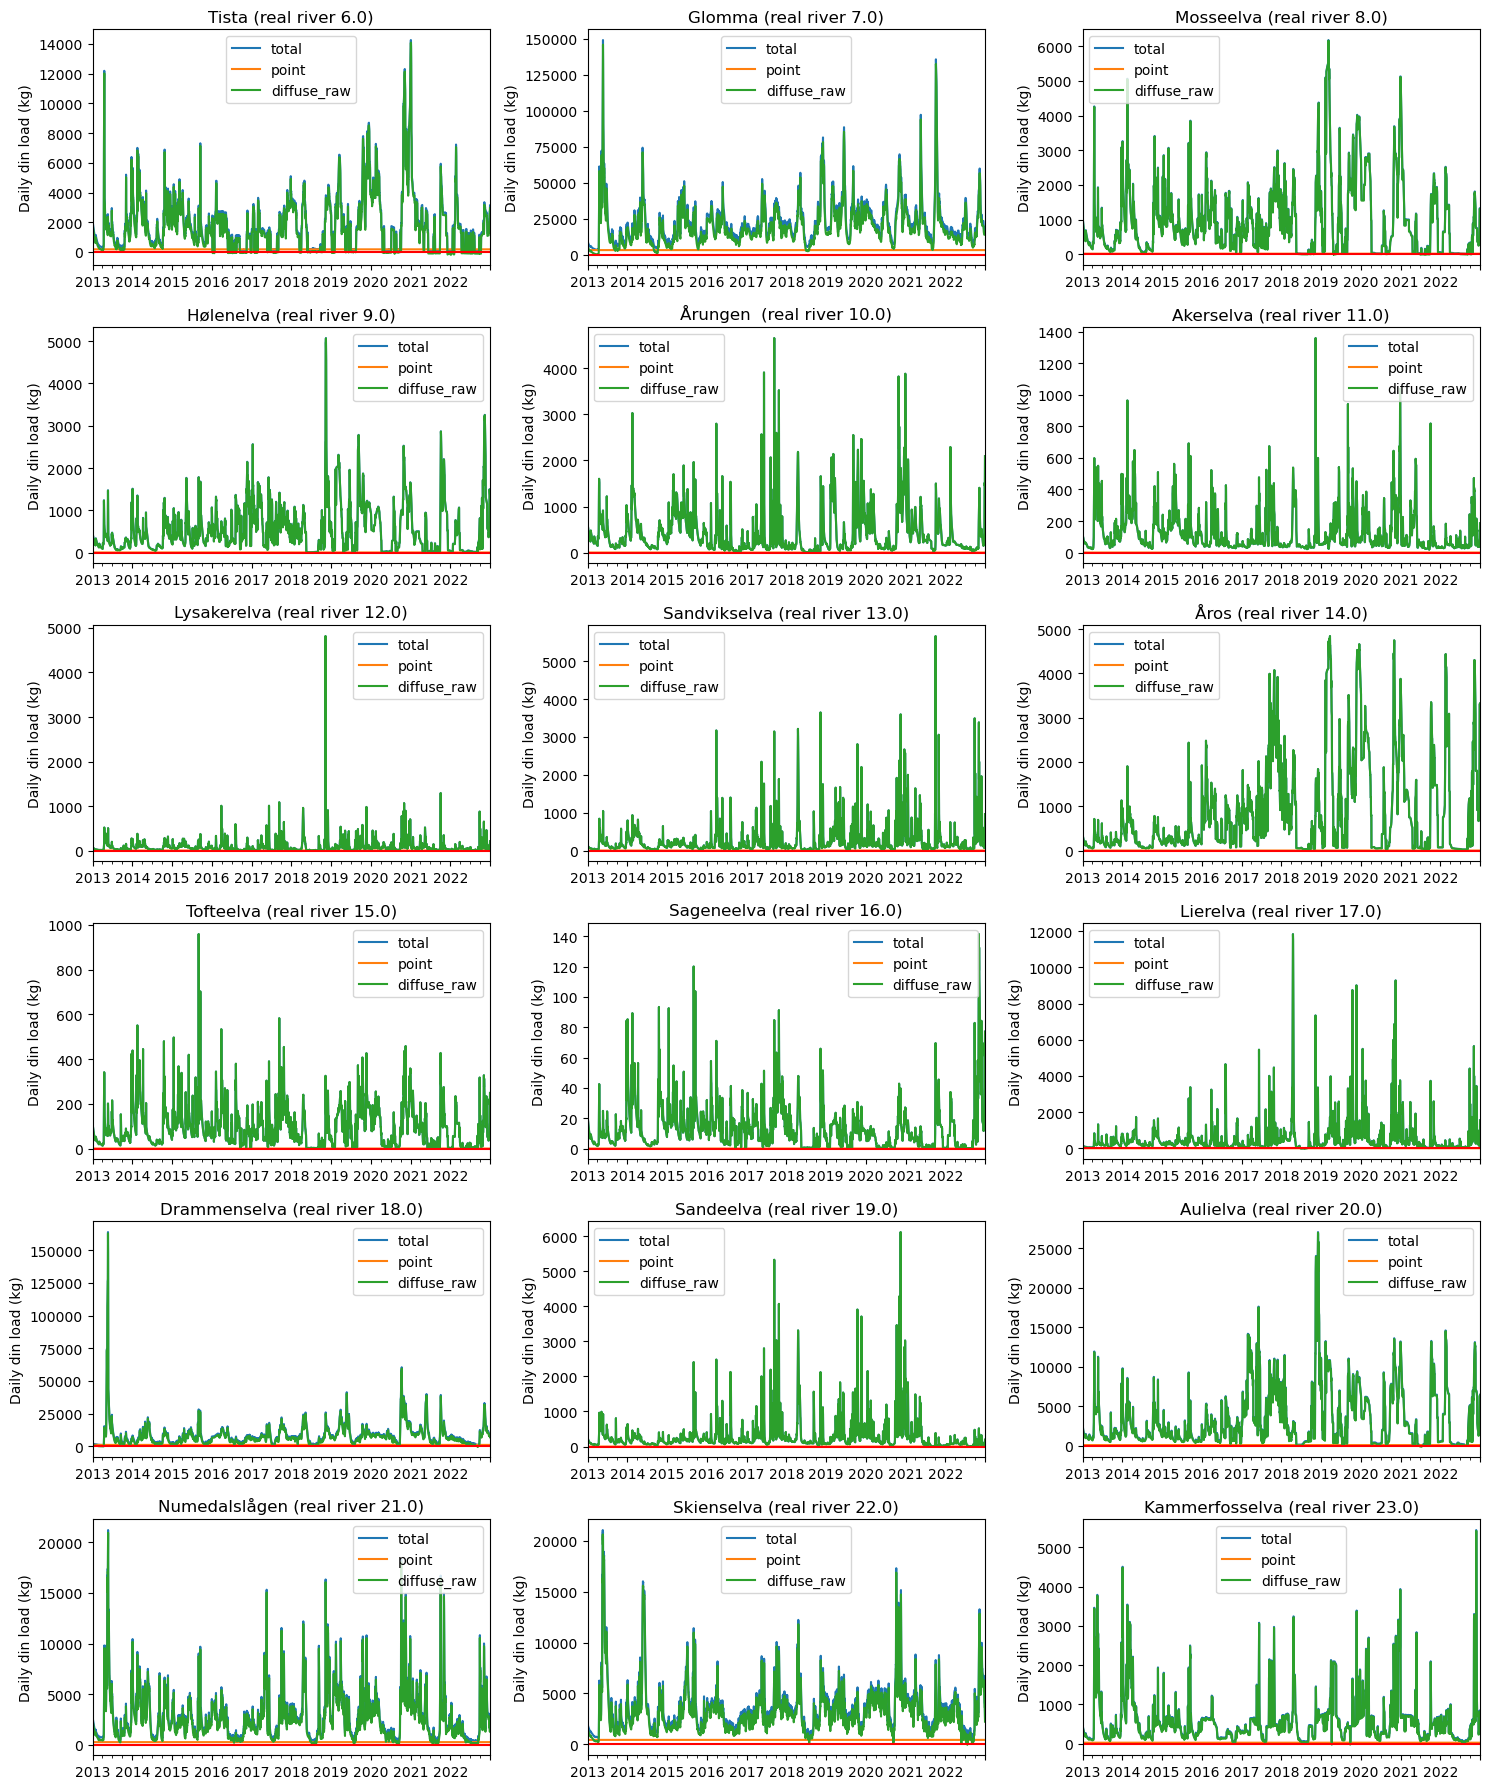

In [21]:
real_rivers = calc_load_df.index.get_level_values('real_river').unique()

n_rows = int(np.ceil(len(real_rivers) / 3))
fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows*3))
axs = axs.flatten()

# For each real_river
for i, real_river in enumerate(real_rivers):
    name = river_meta_df.loc[real_river, 'river_name']
    df = calc_load_df.loc[real_river]
    df.plot(ax=axs[i])
    axs[i].axhline(0, color='r')
    axs[i].set_xlabel('')
    axs[i].set_ylabel(r'Daily %s load (kg)' % par)
    axs[i].set_title(f'{name} (real river {real_river})')
    axs[i].legend()

plt.tight_layout()
plt.show()

**Comments**

**This is extremely influenced by the choice of whether to summarise TEOTIL inputs over the whole vassdragsområde or just the downstream regine associated with the main river**. The whole vassdragsområde includes point source inputs directly to the sea (e.g. VEAS), so of course this approach won't work for the whole vassdragsområde, unless these direct land-sea fluxes are first subtracted from the TEOTIL point sources. Perhaps something to look into for the future. For now, just go with the downstream REGINE as the TEOTIL unit.

Then, point source inputs are minor. The river with the highest point source inputs is in fact Glomma, at 20%. The approach works well everywhere including there, i.e. after subtracting daily point inputs during low flows, we're not going particularly negative.

There are however small negative values that need to be removed. These are small, so it's not worth fiddling too much... Approach: sum up the absolute of the negative over the whole period, divide by the days in the period, and then subtract from the diffuse load for days where this is > (total - point) inputs

## Redistribute negative mass

In [22]:
def remove_negatives(row):
    if row['point'] > row['total']:
        row['leftover'] = row['point'] - row['total']
        row['point'] = row['total']
        row['diffuse'] = 0
    else:
        row['point'] = row['point']
        row['diffuse'] = row['diffuse']
        row['leftover'] = 0
    return row

def redistribute_leftover(df):
    leftover_mass = df['leftover'].sum()
    n_days = len(df[df['diffuse'] > 0])
    mask = df['diffuse'] > 0
    df.loc[mask, 'point'] = df.loc[mask, 'point'] + leftover_mass / n_days
    df.loc[mask, 'diffuse'] = df.loc[mask, 'total'] - df.loc[mask, 'point']
    df['leftover'] = 0
    return df


In [23]:
# Apply to real data
calc_load_df = daily_load_df_var.join(daily_point_df, on='real_river', how='outer')

riv_nos = calc_load_df.index.get_level_values(0).unique().tolist()

daily_load_dict = {}  # Do away with multi-indexing! Use a dict instead from now on
                      # Key: river number, returns df with datetime index, one col per source
                      # or combined sources

# Apply to real data
for riv_no in riv_nos:
    df = calc_load_df.loc[riv_no].copy()

    df['diffuse_raw'] = df['total'] - df['point']
    df['diffuse'] = df['diffuse_raw']
    df['leftover'] = 0
    df['point_raw'] = df['point']

    # print(f'Start {riv_no}')
    # print(df.round(1))

    counter = 0
    max_iterations = 20
    while len(df.loc[df['diffuse'] < 0]) > 0:
        # print('iteration %s' % counter)
        if counter >= max_iterations:
            print(f"Maximum number of iterations reached: {max_iterations}")
            break
        df = df.apply(remove_negatives, axis=1)
        df = redistribute_leftover(df)
        counter += 1

    print(f"River {riv_no}: {counter} iterations to redistribute mass")

    # Check original point source inputs and final ones are equal
    if df['point_raw'].sum().round(1) != df['point'].sum().round(1):
        print("New point source doesn't add up")

    df = df[['total', 'diffuse', 'point']]
    daily_load_dict[riv_no] = df

River 6.0: 3 iterations to redistribute mass
River 7.0: 0 iterations to redistribute mass
River 8.0: 2 iterations to redistribute mass
River 9.0: 0 iterations to redistribute mass
River 10.0: 0 iterations to redistribute mass
River 11.0: 0 iterations to redistribute mass
River 12.0: 0 iterations to redistribute mass
River 13.0: 0 iterations to redistribute mass
River 14.0: 0 iterations to redistribute mass
River 15.0: 0 iterations to redistribute mass
River 16.0: 0 iterations to redistribute mass
River 17.0: 1 iterations to redistribute mass
River 18.0: 1 iterations to redistribute mass
River 19.0: 0 iterations to redistribute mass
River 20.0: 2 iterations to redistribute mass
River 21.0: 0 iterations to redistribute mass
River 22.0: 1 iterations to redistribute mass
River 23.0: 1 iterations to redistribute mass


## Plot result

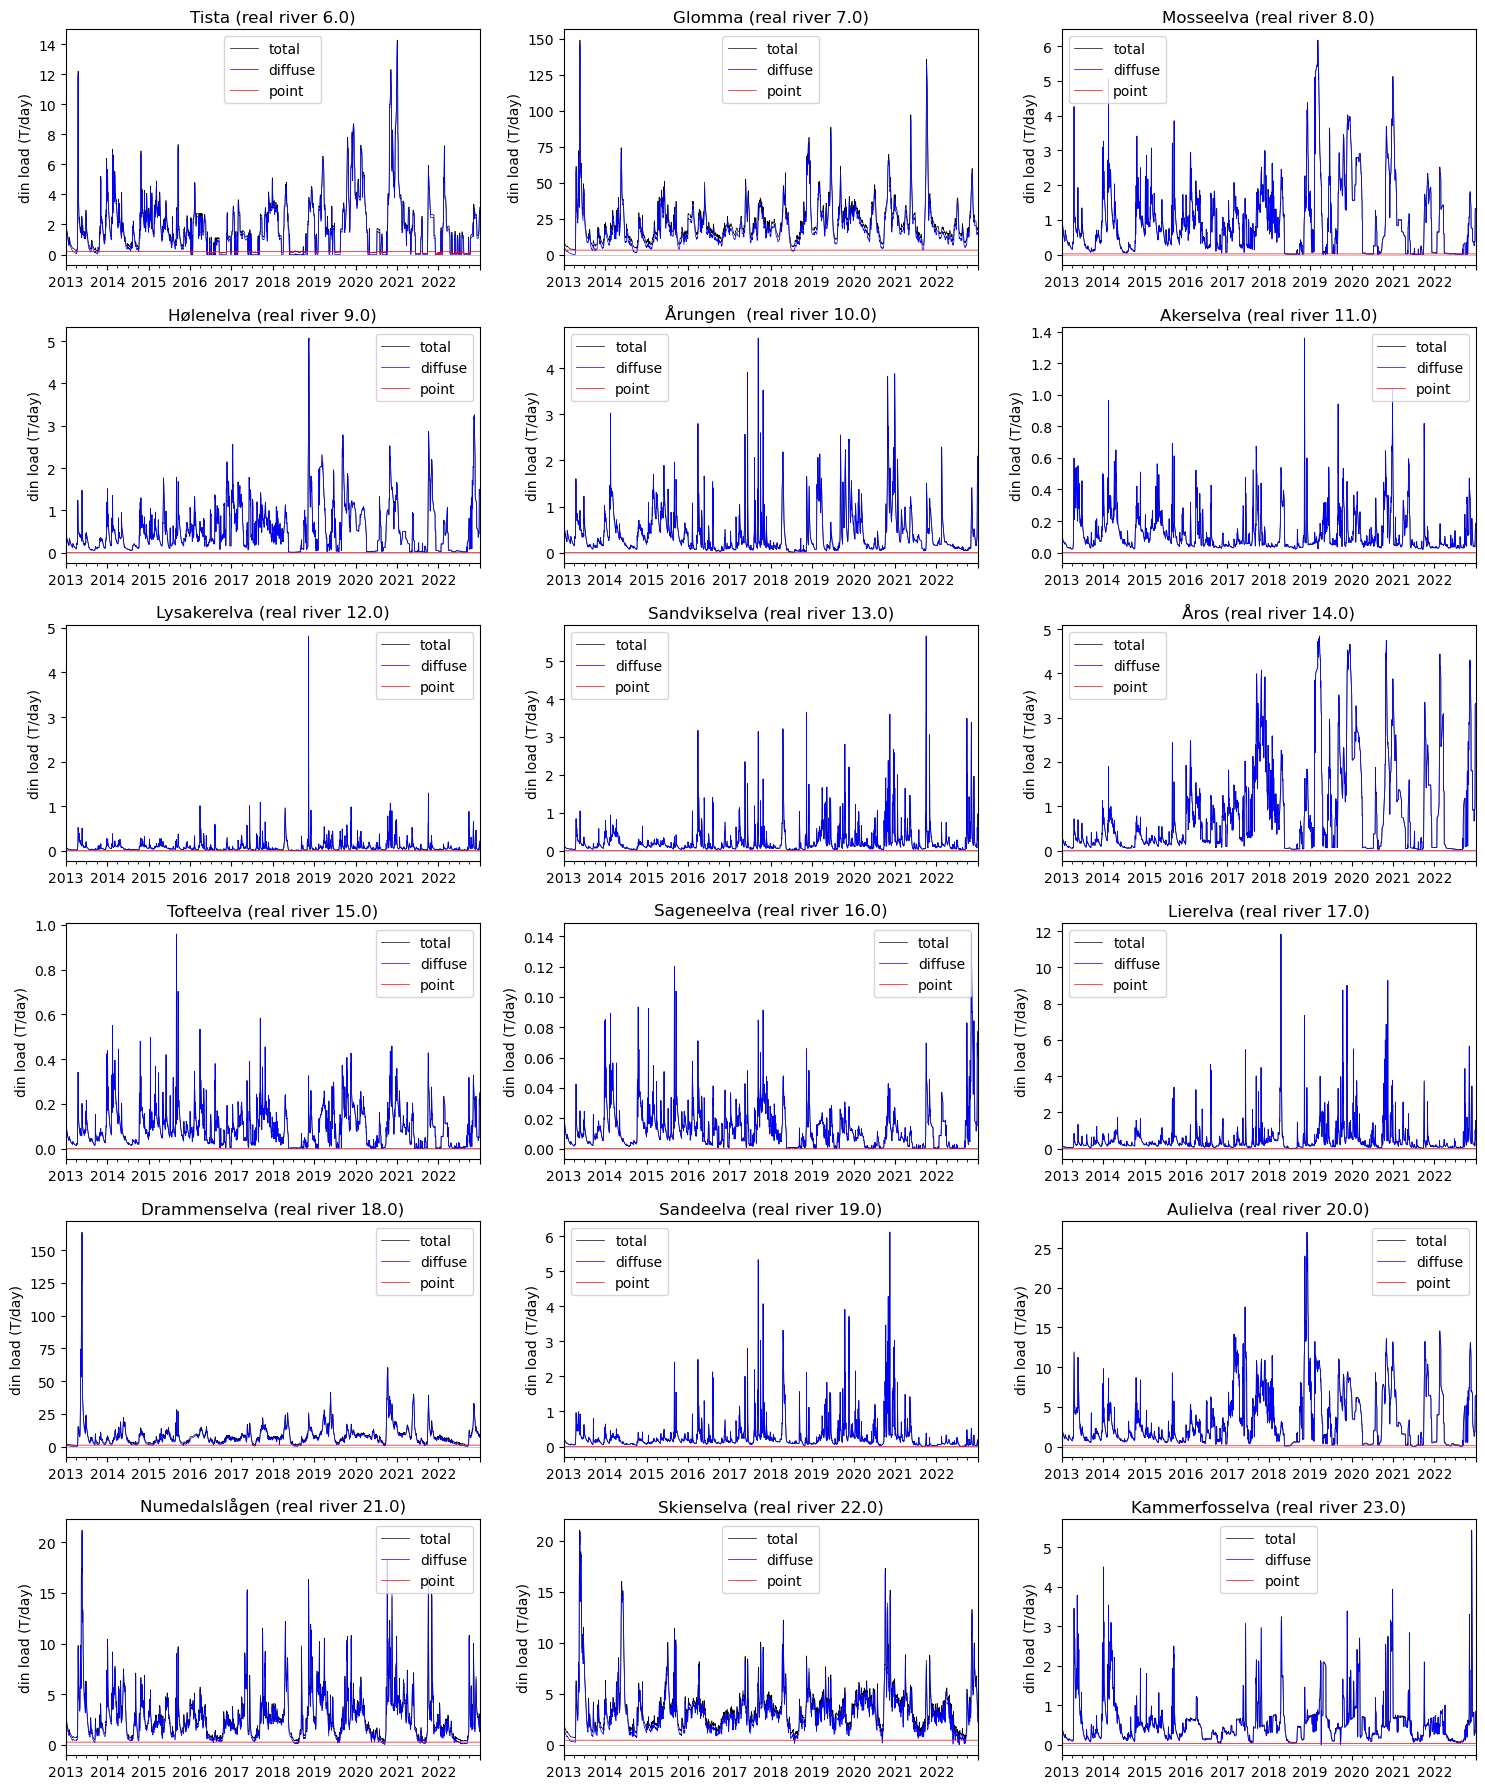

In [24]:
n_rows = int(np.ceil(len(real_rivers) / 3))
fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows * 3))
axs = axs.flatten()
color_li = ["k", "b", "r"]

# For each real_river
for i, real_river in enumerate(real_rivers):
    name = river_meta_df.loc[real_river, "river_name"]
    df = daily_load_dict[real_river] / 1000
    df.plot(ax=axs[i], color=color_li, linewidth=0.5)
    axs[i].axhline(0, color="0.7", linewidth=0.5)
    axs[i].set_xlabel("")
    axs[i].set_ylabel(r"%s load (T/day)" % par)
    axs[i].set_title(f"{name} (real river {real_river})")
    axs[i].legend()

plt.tight_layout()
fpath = os.path.join(fig_folder, f"daily_riv-only_pt-vs-diffuse_ts_v{v}.png")
plt.savefig(fpath)
plt.show()

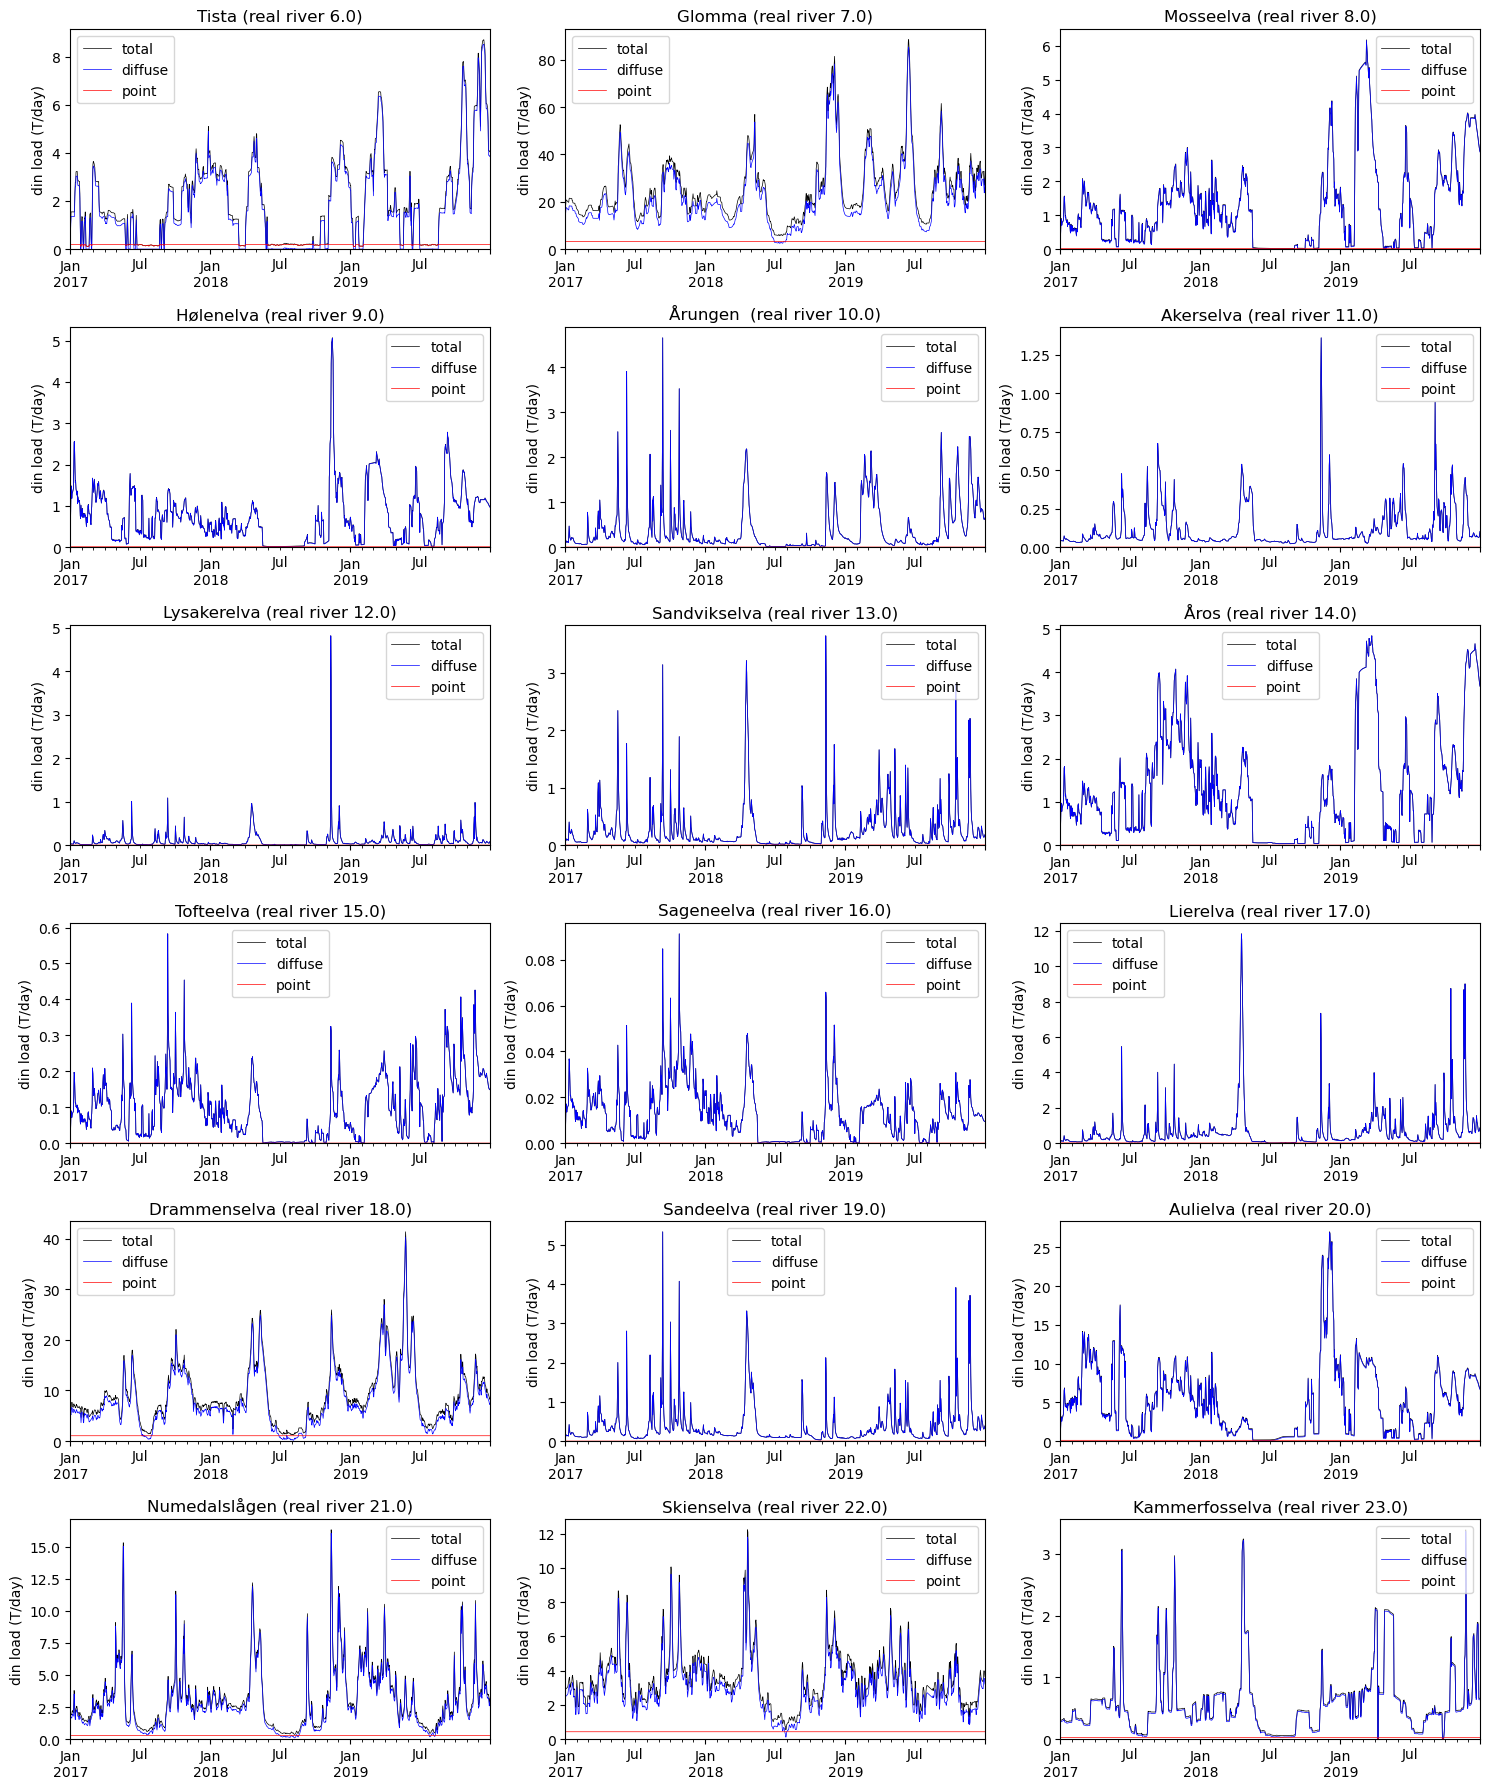

In [26]:
# Plot just baseline period used in of800 modelling

n_rows = int(np.ceil(len(real_rivers) / 3))
fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows * 3))
axs = axs.flatten()
color_li = ["k", "b", "r"]

# For each real_river
for i, real_river in enumerate(real_rivers):
    name = river_meta_df.loc[real_river, "river_name"]
    df = daily_load_dict[real_river] / 1000
    df.loc['2017':'2019'].plot(ax=axs[i], color=color_li, linewidth=0.5)
    # axs[i].axhline(0, color="0.7", linewidth=0.5)
    axs[i].set_ylim(ymin=0)
    axs[i].set_xlabel("")
    axs[i].set_ylabel(r"%s load (T/day)" % par)
    axs[i].set_title(f"{name} (real river {real_river})")
    axs[i].legend()

plt.tight_layout()
fpath = os.path.join(fig_folder, f"daily_riv-only_pt-vs-diffuse_ts_v{v}_2017-2019.png")
plt.savefig(fpath)
plt.show()

# Daily loads from all sectors

Do this based on:
1) The proportion of point source inputs which are large sewage vs industry
2) The proportion of diffuse source inputs which are agriculture, urban and spredt (the rest are "natural")

Then estimate daily loads as this proportion multiplied by the total daily load from point of diffuse sources.

In [27]:
for riv_no in riv_nos:
    # Alter df inplace in the dictionary (unless make a copy here)
    df = daily_load_dict[riv_no]

    for source in human_diffuse_source_li:
        df[source] = f_sector_diffuse_df.loc[riv_no, source] * df["diffuse"]

    for source in point_source_li:
        df[source] = f_sector_point_df.loc[riv_no, source] * df["point"]
        # f_sector_point_df has NaNs where the total point load was 0. Results in
        # NaNs for the daily load per sector. Replace with 0
        df[source]= df[source].fillna(0)

    df["background"] = df["total"] - df[human_diffuse_source_li + point_source_li].sum(axis=1)

    # Rename 'spredt'
    df.rename(columns={"spredt": "small-wastewater"}, inplace=True)

If none of the rivers have any aquaculture inputs (they probably shouldn't), then drop this column altogether

In [28]:
rivs_with_aquaculture = []
for riv_no in riv_nos:
    # Alter df inplace in the dictionary (unless make a copy here)
    df = daily_load_dict[riv_no]
    if df['aquaculture'].eq(0).all():
        # print(f'{riv_no}: all aquaculture inputs = 0')
        pass
    else:
        rivs_with_aquaculture.append(riv_no)

if len(rivs_with_aquaculture) == 0:
    print('Dropping aquaculture column')
    for riv_no in riv_nos:
        df = daily_load_dict[riv_no]
        df.drop('aquaculture', axis=1, inplace=True)
else:
    print(f'Rivers with aquaculture inputs: {rivs_with_aquaculture}')

Dropping aquaculture column


In [29]:
# Quick look at output e.g. for Glomma
daily_load_dict[7].head()

total      diffuse        point  agriculture  \
date                                                              
2013-01-01  10715.475200  7493.121903  3222.353297  5535.845618   
2013-01-02   9554.927811  6332.574514  3222.353297  4678.444490   
2013-01-03   8966.079073  5743.725776  3222.353297  4243.408766   
2013-01-04   8819.291185  5596.937888  3222.353297  4134.963302   
2013-01-05   8609.265870  5386.912574  3222.353297  3979.798641   

            small-wastewater       urban  industry  large-wastewater  \
date                                                                   
2013-01-01        224.802207  250.646757  6.799506        3215.55379   
2013-01-02        189.984461  211.826164  6.799506        3215.55379   
2013-01-03        172.318327  192.129030  6.799506        3215.55379   
2013-01-04        167.914523  187.218939  6.799506        3215.55379   
2013-01-05        161.613524  180.193541  6.799506        3215.55379   

             background  
date                     
2013-01-01  1481.827321  
2013-01-02  1252.319400  
2013-01-03  1135.869653  
2013-01-04  1106.841125  
2013-01-05  1065.306868

In [38]:
glomma_f_sector_s

agriculture-background    0.070522
agriculture               0.634694
aquaculture               0.000000
industry                  0.000297
lake                      0.029771
large-wastewater          0.140603
spredt                    0.025774
upland                    0.021915
urban                     0.028737
wood                      0.047686
Name: 7, dtype: float64

In [68]:
# Quick look at seasonality
glomma_df = daily_load_dict[7][['total', 'agriculture', 'large-wastewater']].copy()
glomma_df.columns = ['L_total', 'L_agri', 'L_wwtw']

glomma_df['agri_pc'] = 100 * glomma_df['L_agri'] / glomma_df['L_total']
glomma_df['wwtw_pc'] = 100 * glomma_df['L_wwtw'] / glomma_df['L_total']

glomma_df.loc['2018', ['agri_pc', 'wwtw_pc']].plot(subplots=False, figsize=(8, 4))
plt.ylabel('Proportion of total (%)')
plt.xlabel('')
plt.show()

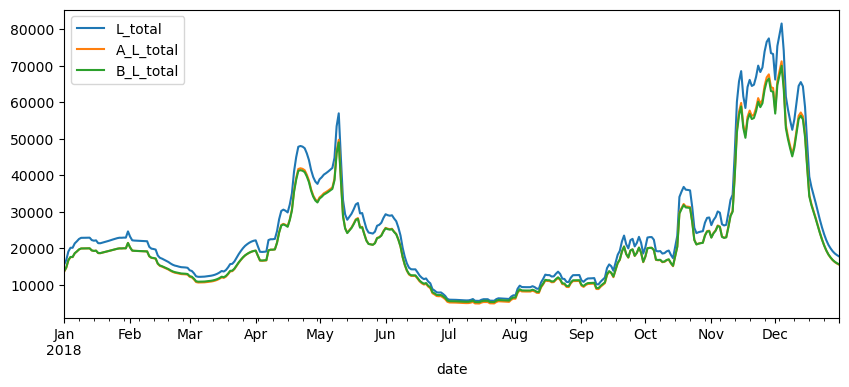

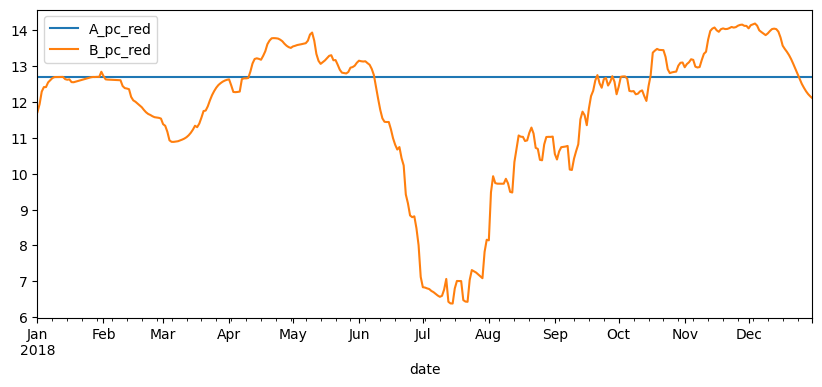

L_total        L_agri      L_wwtw    agri_pc    wwtw_pc  \
date                                                                       
2013-01-01  10715.475200   5535.845618  3215.55379  51.662157  30.008504   
2013-01-02   9554.927811   4678.444490  3215.55379  48.963682  33.653355   
2013-01-03   8966.079073   4243.408766  3215.55379  47.327363  35.863545   
2013-01-04   8819.291185   4134.963302  3215.55379  46.885438  36.460456   
2013-01-05   8609.265870   3979.798641  3215.55379  46.226922  37.349919   
...                  ...           ...         ...        ...        ...   
2022-12-27  17153.715778  10292.355168  3215.55379  60.000733  18.745523   
2022-12-28  18599.245036  11360.298132  3215.55379  61.079351  17.288625   
2022-12-29  18901.583189  11583.662620  3215.55379  61.284087  17.012087   
2022-12-30  18908.559767  11588.816848  3215.55379  61.288734  17.005810   
2022-12-31  18073.752828  10972.069597  3215.55379  60.707202  17.791290   

            A_red-ra   A_red-agri  A_red-total     A_L_total  B_red-ra  \
date                                                                     
2013-01-01       0.0  1360.210072  1360.210072   9355.265128       0.0   
2013-01-02       0.0  1212.891524  1212.891524   8342.036287       0.0   
2013-01-03       0.0  1138.143744  1138.143744   7827.935329       0.0   
2013-01-04       0.0  1119.510658  1119.510658   7699.780526       0.0   
2013-01-05       0.0  1092.850287  1092.850287   7516.415583       0.0   
...              ...          ...          ...           ...       ...   
2022-12-27       0.0  2177.472911  2177.472911  14976.242867       0.0   
2022-12-28       0.0  2360.966729  2360.966729  16238.278307       0.0   
2022-12-29       0.0  2399.345185  2399.345185  16502.238004       0.0   
2022-12-30       0.0  2400.230784  2400.230784  16508.328983       0.0   
2022-12-31       0.0  2294.261353  2294.261353  15779.491474       0.0   

             B_red-agri  B_red-total     B_L_total    diff_A_B   A_pc_red  \
date                                                                        
2013-01-01  1107.169124  1107.169124   9608.306076 -253.040948  12.693885   
2013-01-02   935.688898   935.688898   8619.238913 -277.202626  12.693885   
2013-01-03   848.681753   848.681753   8117.397320 -289.461991  12.693885   
2013-01-04   826.992660   826.992660   7992.298524 -292.517998  12.693885   
2013-01-05   795.959728   795.959728   7813.306142 -296.890559  12.693885   
...                 ...          ...           ...         ...        ...   
2022-12-27  2058.471034  2058.471034  15095.244744 -119.001877  12.693885   
2022-12-28  2272.059626  2272.059626  16327.185410  -88.907102  12.693885   
2022-12-29  2316.732524  2316.732524  16584.850665  -82.612661  12.693885   
2022-12-30  2317.763370  2317.763370  16590.796397  -82.467414  12.693885   
2022-12-31  2194.413919  2194.413919  15879.338908  -99.847434  12.693885   

             B_pc_red  
date                   
2013-01-01  10.332431  
2013-01-02   9.792736  
2013-01-03   9.465473  
2013-01-04   9.377088  
2013-01-05   9.245384  
...               ...  
2022-12-27  12.000147  
2022-12-28  12.215870  
2022-12-29  12.256817  
2022-12-30  12.257747  
2022-12-31  12.141440  

[3652 rows x 16 columns]

In [77]:
# Compare scenarios

# Proportion removed compared to baseline (1=all, 0=none)
f_ra = 0
f_agri = 0.2

# Firstly, assume set reduction according to annual source apportionment
glomma_f_sector_s = f_sector_df.loc[7, :].copy()

glomma_df['A_red-ra'] = glomma_df['L_total'] * glomma_f_sector_s['large-wastewater'] * f_ra
glomma_df['A_red-agri'] = glomma_df['L_total'] * glomma_f_sector_s['agriculture'] * f_agri
glomma_df['A_red-total'] = glomma_df['A_red-ra'] + glomma_df['A_red-agri']
glomma_df['A_L_total'] = glomma_df['L_total'] - glomma_df['A_red-total']
glomma_df['A_pc_red'] = 100 * glomma_df['A_red-total'] / glomma_df['L_total']

glomma_df['B_red-ra'] = glomma_df['L_wwtw'] * f_ra
glomma_df['B_red-agri'] = glomma_df['L_agri'] * f_agri
glomma_df['B_red-total'] = glomma_df['B_red-ra'] + glomma_df['B_red-agri']
glomma_df['B_L_total'] = glomma_df['L_total'] - glomma_df['B_red-total']
glomma_df['B_pc_red'] = 100 * glomma_df['B_red-total'] / glomma_df['L_total']

glomma_df['diff_A_B'] = glomma_df['A_L_total'] - glomma_df['B_L_total']

glomma_df.loc['2018', ['L_total', 'A_L_total', 'B_L_total']].plot(subplots=False, figsize=(10, 4))
plt.show()

glomma_df.loc['2018', ['A_pc_red', 'B_pc_red']].plot(figsize=(10, 4))
plt.show()

glomma_df

## Plot by real river

**To do:**
- Turn into stacked line chart?
- Use this function for plots above (& move function up!)

In [26]:
cols_to_plot = ['total', 'large-wastewater', 'agriculture', 'urban', 'industry', 'small-wastewater', 'background']


def plot_timeseries_allrivs(real_rivers_li, daily_load_dict, cols_to_plot, fpath):
    n_rows = int(np.ceil(len(real_rivers_li) / 3))
    fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows*3), sharex=False, sharey=False)
    axs = axs.flatten()
    # color_li = ['k', 'r', '']

    # For each real_river
    for i, real_river in enumerate(real_rivers_li):
        name = river_meta_df.loc[real_river, 'river_name']
        df = daily_load_dict[real_river].copy()/1000  # to T/yr
        df[cols_to_plot].plot(ax=axs[i], linewidth=0.5, legend=False)
        axs[i].set_xlabel('')
        axs[i].set_ylabel(r'DIN load (T/day)')
        axs[i].set_title(f'{name} (real river {real_river})')

    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.12, 0.5))

    plt.tight_layout()
    # fig.autofmt_xdate()

    plt.savefig(fpath)

    plt.show()

fpath = os.path.join(fig_folder, f"daily_riv-only_sector-inputs_ts_v{v}.png")
plot_timeseries_allrivs(real_rivers, daily_load_dict, cols_to_plot, fpath)

# Generate scenarios

## WWTW scenarios
For WWTW, the scenario is generated externally using TEOTIL. Here, James converted all WWTWs to have 80% treatment efficiency and then re-ran TEOTIL.

In [28]:
# Read scenario teotil data and average over time
scen_teotil_df = read_teotil_data(teotil_scen_res_fpath)
scen_teotil_av_df = teotil_average_over_years(scen_teotil_df)

# Calculate factor reductions from  this scenario per real river
col = 'large-wastewater'
f_wwtw_scenario_df = scen_teotil_av_df[col] / bsl_teotil_av_df[col]

# Have some NaNs (when baseline large wwtw inputs = 0). Replace any NaNs with 0
# (i.e. no change)
f_wwtw_scenario_df.fillna(0, inplace=True)

f_wwtw_scenario_df

real_river
6     0.228189
7     0.296954
8     0.247137
9     0.237242
10    0.225176
11    0.221884
12    0.225553
13    0.228480
14    0.000000
15    0.000000
16    0.000000
17    0.246069
18    0.237908
19    0.000000
20    0.230426
21    0.234059
22    0.255583
23    0.230199
Name: large-wastewater, dtype: float64

The new WWTW inputs are around 23-30% of the original, i.e. a 70-80'ish percent reduction

In [30]:
wwtw_scen_load_dict = {}  # key: real riv no

for riv_no in daily_load_dict.keys():
    # Copy baseline data
    scen_load_df = daily_load_dict[riv_no].copy()[['agriculture', 'small-wastewater', 'urban', 'industry', 'background', 'large-wastewater']]

    # Reduce large wastewater by a set proportion per real river
    scen_load_df['large-wastewater'] = scen_load_df['large-wastewater'] * f_wwtw_scenario_df.loc[riv_no]

    # Add new total column
    scen_load_df['total'] = scen_load_df.sum(axis=1)

    wwtw_scen_load_dict[riv_no] = scen_load_df

# Quick check of output
print(f_wwtw_scenario_df.loc[7])
print(daily_load_dict[7]['large-wastewater'].head(2))
print(wwtw_scen_load_dict[7]['large-wastewater'].head(2))

0.2969537651196783
date
2013-01-01    3288.813767
2013-01-02    3288.813767
Name: large-wastewater, dtype: float64
date
2013-01-01    976.625631
2013-01-02    976.625631
Name: large-wastewater, dtype: float64


## Other sectors: user-supplied % reduction

In [31]:
# Factor giving proportion of the original load per sector
# (i.e. new load = old load * factor)

# # Read in scenarios info?
# scen_setup_df = pd.read_csv(scenario_setup_fpath, index_col=0)

# Or input directly
scenario = 'RA80-J10'
scenario_dict = {
    "agriculture": 0.9,
    "industry": 1,
    "large-wastewater": 1,  # Don't change; taken care of in previous section
    "small-wastewater": 1,
    "urban": 1,
    "background": 1
}
scen_setup_df = pd.DataFrame(list(scenario_dict.items()), columns=['Sector', scenario])
scen_setup_df.set_index('Sector', inplace=True)

scen_setup_df

RA80-J10
Sector                    
agriculture            0.9
industry               1.0
large-wastewater       1.0
small-wastewater       1.0
urban                  1.0
background             1.0

In [32]:
main_results_dict = {}  # key: (scenario, type), where type is 'loads', 'factor', 'conc'
                        # Returns loads_dict, factor_dict, conc_dict (key: real riv no)

for scenario in scen_setup_df.columns:

    scenario_loads_dict = {}
    scenario_factor_dict = {}
    scenario_conc_dict = {}  # Key: river

    for riv_no in daily_load_dict.keys():

        baseline_df = daily_load_dict[riv_no].copy()

        # Calculate loads per sector for the scenario
        scen_load_df = pd.DataFrame(index=baseline_df.index)

        for source in scen_setup_df.index:
            scen_load_df[source] = baseline_df[source] * scen_setup_df.loc[source, scenario]

        # Replace large-wwtw column with wwtw scenario already calculated above
        scen_load_df['large-wastewater'] = wwtw_scen_load_dict[riv_no]['large-wastewater']

        # Calculate new total load
        scen_load_df['total'] = scen_load_df.sum(axis=1)
        scenario_loads_dict[riv_no] = scen_load_df

        # ---------------------------------------------------------
        # Factor to multiply concentration by to get new concentration
        factor_s = scen_load_df['total'] / baseline_df['total']
        # Replace any NaNs with 1 (i.e. concentration is unchanged)
        factor_s.fillna(1, inplace=True)
        factor_s.name = 'factor'
        scenario_factor_dict[riv_no] = factor_s

        # ---------------------------------------------------------
        # Calculate new daily concentration: C_scenario = L_scenario / Q
        # or (equivalent): C_scenario = C_baseline * (L_scenario/L_baseline)
        temp_load_df = scen_load_df[["total"]].copy()
        temp_load_df.columns = [f"{par}_load"]

        # Adjust the time component of the datetime index to be centered on midday
        # to match chem_df
        temp_load_df.index = temp_load_df.index + pd.tseries.offsets.DateOffset(
            hours=12
        )
        factor_s = factor_s.copy()  # To not alter dictionary item inplace
        factor_s.index = factor_s.index + pd.tseries.offsets.DateOffset(hours=12)

        # Join new total load to conc_df, and the factor
        df = conc_df.loc[conc_df["real_river"] == riv_no].copy()
        df.set_index("river_time", inplace=True)
        df = pd.merge(
            df,
            temp_load_df[[f"{par}_load"]],
            left_index=True,
            right_index=True,
            how="left",
        )
        df = pd.merge(df, factor_s, left_index=True, right_index=True, how="left")

        # Calculate new value for par (two methods to validate; they produce the same result)
        # df[f"{par}_new"] = df['din_load'] / df['river_transport'] * 1/86400 * 10**9 * 10**-3
        df[f"{par}"] = df[f"{par}"] * df["factor"]

        if par == 'din':
            # Assume NH4 and NO3 are reduced by the same amount as din overall
            df['river_NH4N'] = df['river_NH4N'] * df["factor"]
            df['river_NO3NO2N'] = df['river_NO3NO2N'] * df["factor"]

            # Calculate new TOTN
            df['river_TOTN'] = df['din'] + df['river_DON'] + df['river_PON']

            # Drop cols used in calculation
            df.drop(derived_chemvar_dict[species] + [f"{par}_load", 'factor'], axis=1, inplace=True)

        # Bit of QC
        # Check for NaNs
        if df.isna().sum().sum() > 0:
            print(f"{riv_no} has NaNs. Needs fixing!")

        scenario_conc_dict[riv_no] = df

    main_results_dict[(scenario, 'loads')] = scenario_loads_dict
    main_results_dict[(scenario, 'factor')] = scenario_factor_dict
    main_results_dict[(scenario, 'conc')] = scenario_conc_dict

## Quick check of output

All looks ok for Glomma

In [33]:
riv = 7
scen = 'RA80-J10'
st = '2017-07-01'
end = '2017-07-10'
par = 'river_NO3NO2N'

scenario_loads_dict = main_results_dict[(scen, 'loads')]
scenario_factor_dict = main_results_dict[(scen, 'factor')]
scenario_conc_dict = main_results_dict[(scen, 'conc')]

# Baseline loads per sector + total
bsl_load = daily_load_dict[riv].copy().loc[st: end, 'total']
daily_load_dict[riv].copy().loc[st: end]

total       diffuse        point   agriculture  \
date                                                                
2017-07-01  17055.477776  13759.488112  3295.989665  10095.219262   
2017-07-02  14989.181035  11693.191370  3295.989665   8579.194937   
2017-07-03  13921.342564  10625.352899  3295.989665   7795.730944   
2017-07-04  13273.747141   9977.757476  3295.989665   7320.595697   
2017-07-05  12547.657287   9251.667622  3295.989665   6787.869754   
2017-07-06  11987.323530   8691.333866  3295.989665   6376.757648   
2017-07-07  12041.199219   8745.209554  3295.989665   6416.285782   
2017-07-08  11556.853873   8260.864208  3295.989665   6060.925726   
2017-07-09  11623.461926   8327.472261  3295.989665   6109.795487   
2017-07-10  12059.897904   8763.908240  3295.989665   6430.004848   

            small-wastewater       urban  industry  large-wastewater  \
date                                                                   
2017-07-01        497.481455  455.537282  7.175898       3288.813767   
2017-07-02        422.773421  387.128109  7.175898       3288.813767   
2017-07-03        384.165165  351.775032  7.175898       3288.813767   
2017-07-04        360.751015  330.335001  7.175898       3288.813767   
2017-07-05        334.498859  306.296243  7.175898       3288.813767   
2017-07-06        314.239700  287.745196  7.175898       3288.813767   
2017-07-07        316.187604  289.528866  7.175898       3288.813767   
2017-07-08        298.675845  273.493577  7.175898       3288.813767   
2017-07-09        301.084094  275.698779  7.175898       3288.813767   
2017-07-10        316.863664  290.147926  7.175898       3288.813767   

             background  
date                     
2017-07-01  2711.250113  
2017-07-02  2304.094903  
2017-07-03  2093.681758  
2017-07-04  1966.075763  
2017-07-05  1823.002766  
2017-07-06  1712.591322  
2017-07-07  1723.207303  
2017-07-08  1627.769059  
2017-07-09  1640.893900  
2017-07-10  1726.891801

In [34]:
# Scenario loads
scen_load = scenario_loads_dict[riv].copy().loc[st: end, 'total']
scenario_loads_dict[riv].copy().loc[st: end]

agriculture  industry  large-wastewater  small-wastewater  \
date                                                                    
2017-07-01  9085.697336  7.175898        976.625631        497.481455   
2017-07-02  7721.275444  7.175898        976.625631        422.773421   
2017-07-03  7016.157850  7.175898        976.625631        384.165165   
2017-07-04  6588.536127  7.175898        976.625631        360.751015   
2017-07-05  6109.082778  7.175898        976.625631        334.498859   
2017-07-06  5739.081883  7.175898        976.625631        314.239700   
2017-07-07  5774.657204  7.175898        976.625631        316.187604   
2017-07-08  5454.833153  7.175898        976.625631        298.675845   
2017-07-09  5498.815939  7.175898        976.625631        301.084094   
2017-07-10  5787.004363  7.175898        976.625631        316.863664   

                 urban   background         total  
date                                               
2017-07-01  455.537282  2711.250113  13733.767714  
2017-07-02  387.128109  2304.094903  11819.073405  
2017-07-03  351.775032  2093.681758  10829.581333  
2017-07-04  330.335001  1966.075763  10229.499435  
2017-07-05  306.296243  1823.002766   9556.682175  
2017-07-06  287.745196  1712.591322   9037.459629  
2017-07-07  289.528866  1723.207303   9087.382504  
2017-07-08  273.493577  1627.769059   8638.573164  
2017-07-09  275.698779  1640.893900   8700.294241  
2017-07-10  290.147926  1726.891801   9104.709283

In [35]:
# Factor for calculating concs
scenario_factor_dict[riv].loc[st: end]

date
2017-07-01    0.805241
2017-07-02    0.788507
2017-07-03    0.777912
2017-07-04    0.770656
2017-07-05    0.761631
2017-07-06    0.753918
2017-07-07    0.754691
2017-07-08    0.747485
2017-07-09    0.748511
2017-07-10    0.754957
Name: factor, dtype: float64

In [36]:
scen_load/bsl_load

date
2017-07-01    0.805241
2017-07-02    0.788507
2017-07-03    0.777912
2017-07-04    0.770656
2017-07-05    0.761631
2017-07-06    0.753918
2017-07-07    0.754691
2017-07-08    0.747485
2017-07-09    0.748511
2017-07-10    0.754957
Name: total, dtype: float64

In [37]:
# Original conc
bsl_conc = conc_df.loc[conc_df["real_river"] == riv].set_index('river_time').loc[st: end, par]
conc_df.loc[conc_df["real_river"] == riv].set_index('river_time').loc[st: end]

real_river  river_NH4N  river_NO3NO2N  river_TOTN  \
river_time                                                               
2017-07-01 12:00:00         7.0       3.571        221.693     394.696   
2017-07-02 12:00:00         7.0       3.290        220.572     392.567   
2017-07-03 12:00:00         7.0       3.193        220.190     391.647   
2017-07-04 12:00:00         7.0       3.179        220.115     392.227   
2017-07-05 12:00:00         7.0       3.198        220.108     394.788   
2017-07-06 12:00:00         7.0       3.279        220.151     399.760   
2017-07-07 12:00:00         7.0       3.594        220.378     405.444   
2017-07-08 12:00:00         7.0       4.332        220.960     408.109   
2017-07-09 12:00:00         7.0       5.542        221.999     409.116   
2017-07-10 12:00:00         7.0       6.613        223.046     409.442   

                     river_DON  river_PON  river_transport         din  \
river_time                                                               
2017-07-01 12:00:00    150.665     18.598       876.311157  225.264008   
2017-07-02 12:00:00    150.427     18.113       774.964539  223.863007   
2017-07-03 12:00:00    150.301     17.803       721.305420  223.382004   
2017-07-04 12:00:00    151.000     17.773       688.022644  223.294006   
2017-07-05 12:00:00    153.454     17.866       650.352051  223.306000   
2017-07-06 12:00:00    158.203     17.964       620.964844  223.429993   
2017-07-07 12:00:00    163.239     18.069       622.249023  223.970993   
2017-07-08 12:00:00    164.466     18.185       593.717834  225.292007   
2017-07-09 12:00:00    163.090     18.318       591.235046  227.542007   
2017-07-10 12:00:00    161.142     18.474       607.780029  229.658997   

                            ton  
river_time                       
2017-07-01 12:00:00  169.432007  
2017-07-02 12:00:00  168.705002  
2017-07-03 12:00:00  168.264999  
2017-07-04 12:00:00  168.934006  
2017-07-05 12:00:00  171.481995  
2017-07-06 12:00:00  176.330002  
2017-07-07 12:00:00  181.473007  
2017-07-08 12:00:00  182.815994  
2017-07-09 12:00:00  181.574005  
2017-07-10 12:00:00  179.783005

In [38]:
# New concs
scen_conc = scenario_conc_dict[riv].loc[st: end, par]
scenario_conc_dict[riv].loc[st: end]

real_river  river_NH4N  river_NO3NO2N  river_TOTN  \
river_time                                                               
2017-07-01 12:00:00         7.0    2.875515     178.516264  350.654785   
2017-07-02 12:00:00         7.0    2.594188     173.922555  345.057536   
2017-07-03 12:00:00         7.0    2.483873     171.288473  341.875572   
2017-07-04 12:00:00         7.0    2.449917     169.633054  340.855976   
2017-07-05 12:00:00         7.0    2.435695     167.641031  341.396726   
2017-07-06 12:00:00         7.0    2.472097     165.975814  344.614905   
2017-07-07 12:00:00         7.0    2.712359     166.317253  350.336852   
2017-07-08 12:00:00         7.0    3.238104     165.164252  351.053362   
2017-07-09 12:00:00         7.0    4.148250     166.168791  351.725796   
2017-07-10 12:00:00         7.0    4.992533     168.390230  352.998761   

                     river_DON  river_PON  river_transport  
river_time                                                  
2017-07-01 12:00:00    150.665     18.598       876.311157  
2017-07-02 12:00:00    150.427     18.113       774.964539  
2017-07-03 12:00:00    150.301     17.803       721.305420  
2017-07-04 12:00:00    151.000     17.773       688.022644  
2017-07-05 12:00:00    153.454     17.866       650.352051  
2017-07-06 12:00:00    158.203     17.964       620.964844  
2017-07-07 12:00:00    163.239     18.069       622.249023  
2017-07-08 12:00:00    164.466     18.185       593.717834  
2017-07-09 12:00:00    163.090     18.318       591.235046  
2017-07-10 12:00:00    161.142     18.474       607.780029

In [39]:
scen_load/bsl_load

date
2017-07-01    0.805241
2017-07-02    0.788507
2017-07-03    0.777912
2017-07-04    0.770656
2017-07-05    0.761631
2017-07-06    0.753918
2017-07-07    0.754691
2017-07-08    0.747485
2017-07-09    0.748511
2017-07-10    0.754957
Name: total, dtype: float64

In [40]:
scen_conc/bsl_conc

river_time
2017-07-01 12:00:00    0.805241
2017-07-02 12:00:00    0.788507
2017-07-03 12:00:00    0.777912
2017-07-04 12:00:00    0.770656
2017-07-05 12:00:00    0.761631
2017-07-06 12:00:00    0.753918
2017-07-07 12:00:00    0.754691
2017-07-08 12:00:00    0.747485
2017-07-09 12:00:00    0.748511
2017-07-10 12:00:00    0.754957
Name: river_NO3NO2N, dtype: float64

## Generate netcdf files

Read in Phil's original file, truncate to the period I've updated (i.e. the date which TEOTIL covers), and then update the concentration columns for the variables that have been updated through the scenario.

In [45]:
ds_scen_dict = {}  # key: scenario name

for scenario in scen_setup_df.columns:

    # scenario_loads_dict = main_results_dict[(scenario, 'loads')]
    # scenario_factor_dict = main_results_dict[(scenario, 'factor')]
    scenario_conc_dict = main_results_dict[(scenario, 'conc')]

    update_cols_li = ["river_NH4N", "river_NO3NO2N", "river_TOTN"]

    # Read in original river file & truncate to start and end date of scenarios
    ds_scen = xr.open_dataset(fpath_baseline_data)
    ds_scen = ds_scen.sel(river_time=slice(start_date, end_date))
    print(ds_scen.river_time.data[-1])  # Check not chopped end: ok

    # Update the relevant chemistry values
    for real_river, df in scenario_conc_dict.items():
        df = df.copy().reset_index()  # To not modify it inplace
        df_ds = xr.Dataset.from_dataframe(df)
        for col in update_cols_li:
            ds_scen[col].loc[
                {"real_river": real_river, "river_time": df_ds["river_time"]}
            ] = df_ds[col]

    # Update the 'History' attribute of the ds_scen dataset
    current_date = dt.datetime.now().date().strftime("%Y-%m-%d")
    existing_history = ds_scen.attrs["history"]
    new_history_str = (
        f"; Update {current_date}, Leah JB (NIVA, ljb@nivano): "
        "This is a daily concentration reduction scenario. v2 extends to the full of800 domain"
        "(i.e. includes 3 rivers not included in v1)."
        "See 'make_scenarios.ipynb' in GitHub repository https://github.com/oslofjord-load-reductions/terrestrial-load-scenarios"
    )
    new_history = existing_history + new_history_str
    ds_scen.attrs['history'] = new_history

    # Save
    netcdf_fpath = os.path.join(netcdf_outfolder, f"river_din_reduction_{scenario}_v{v}.nc")
    ds_scen.to_netcdf(netcdf_fpath)
    print(f"Scenario saved: {netcdf_fpath}")
    ds_scen_dict[scenario] = ds_scen
    ds_scen.close()

2022-12-31T12:00:00.000000000
Scenario saved: /home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/river_scenarios/river_din_reduction_RA80-J10_v2.nc


# Quick plot of results

The factor difference between load and concentration should be the same on the plots below. Because the load range is much larger than the concentration range, the scale is much more 'squished', so it doesn't look like it by eye. But if you zoom in (commented-out code below), then it is correct.

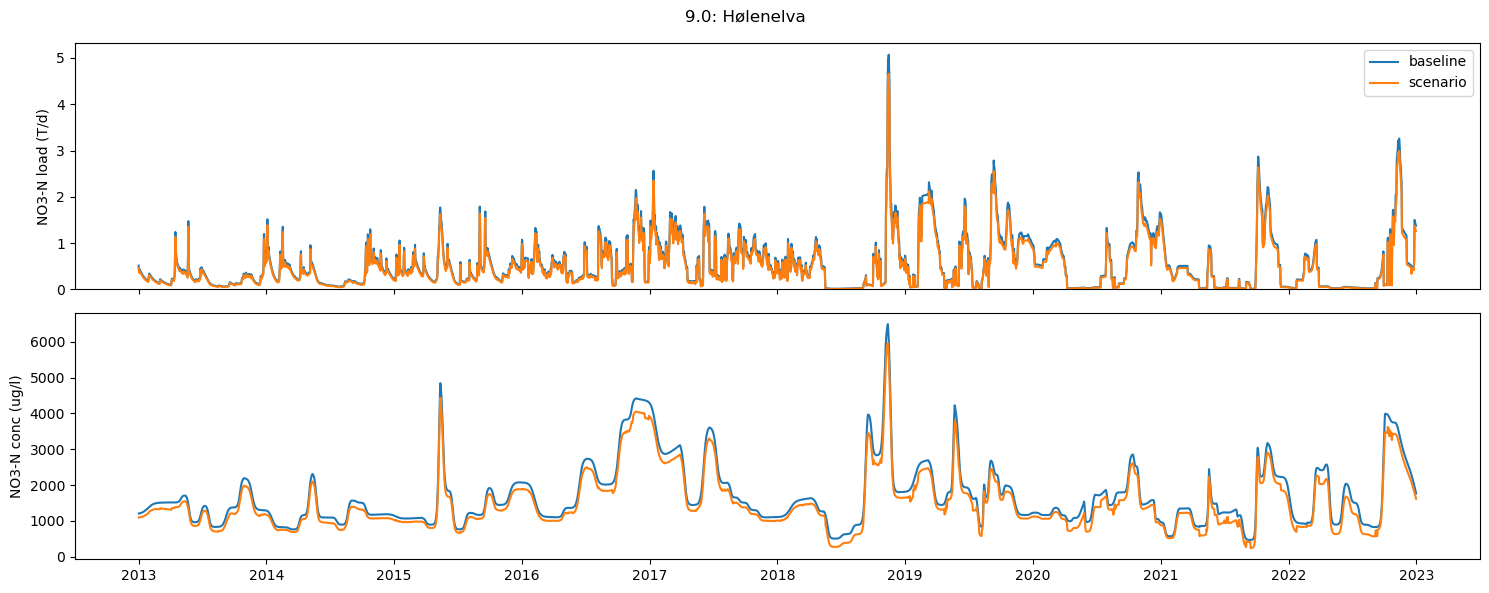

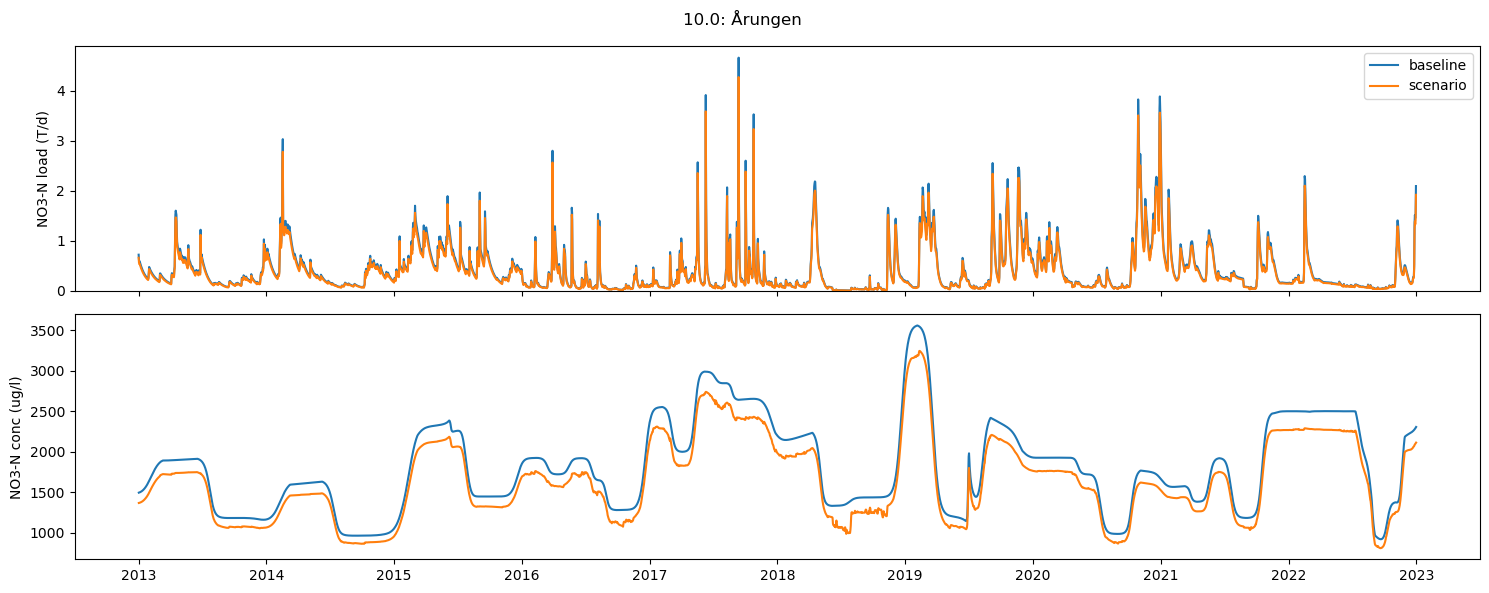

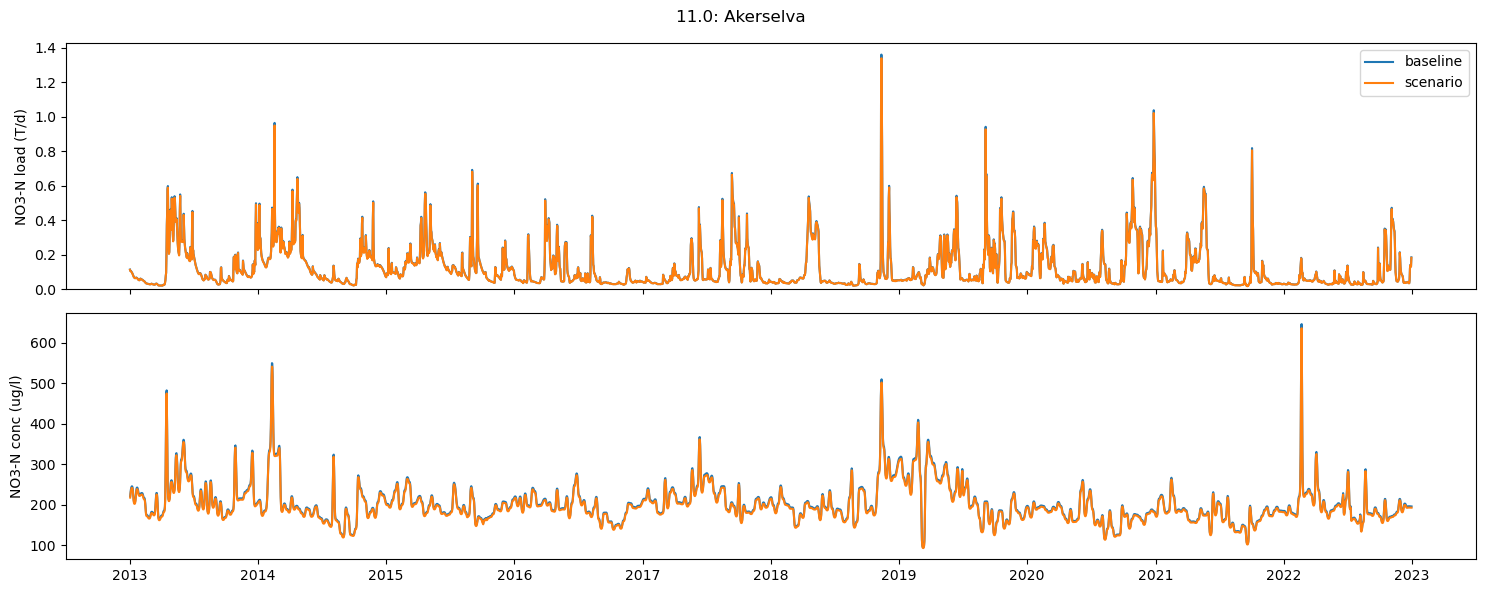

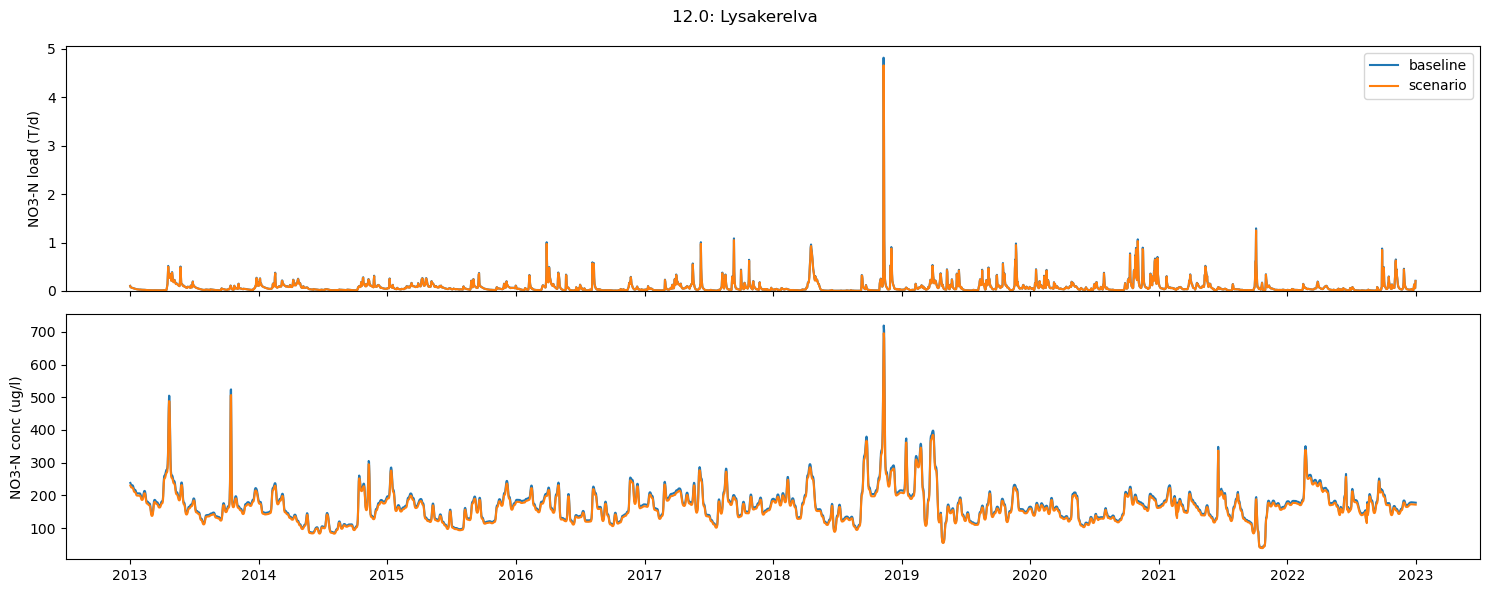

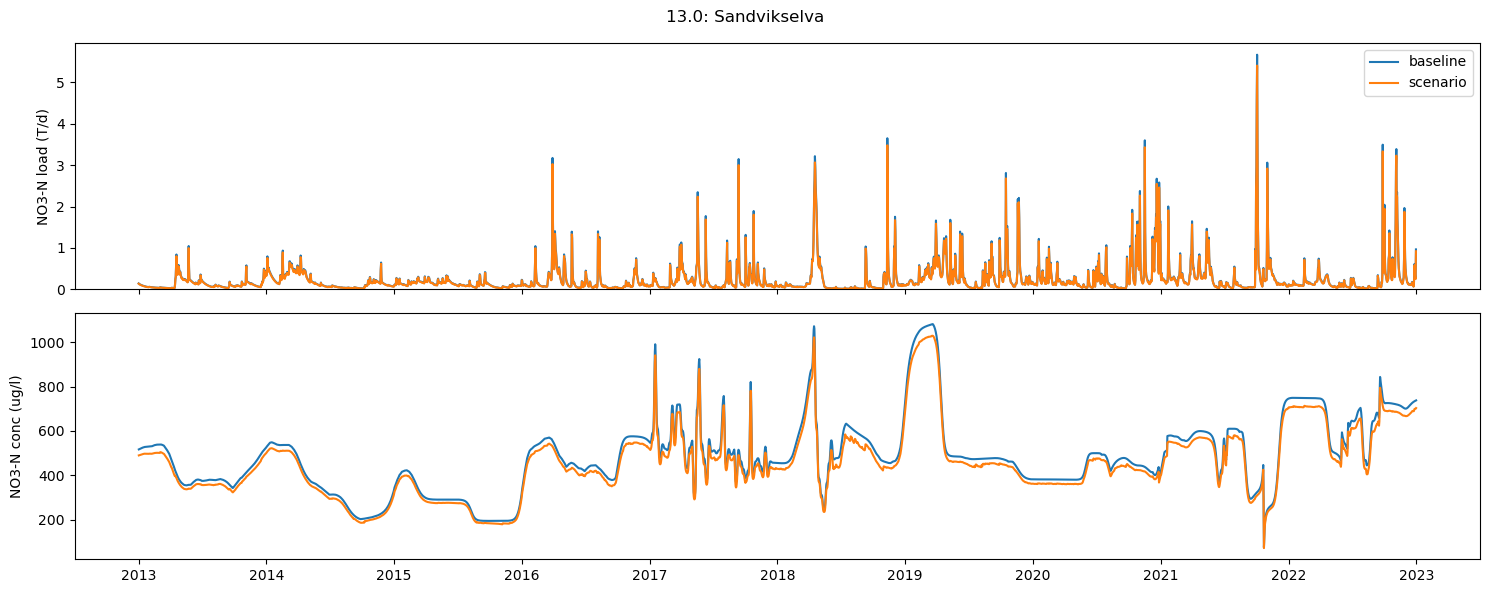

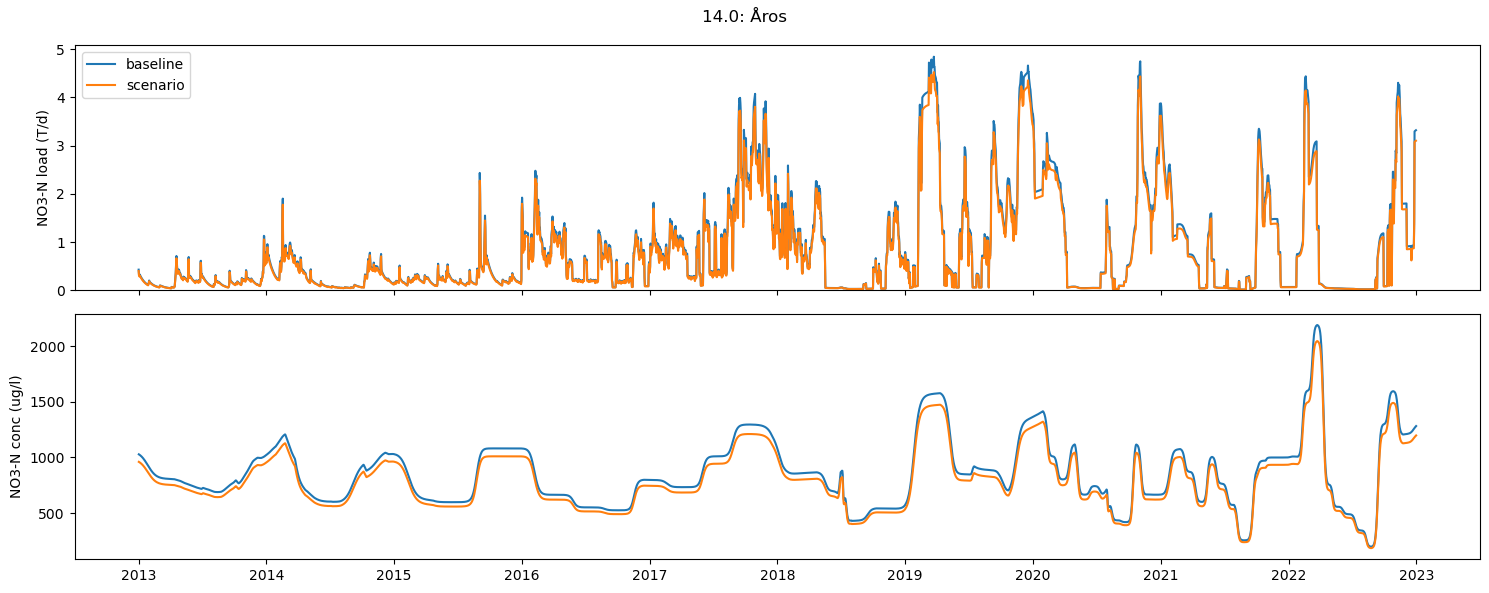

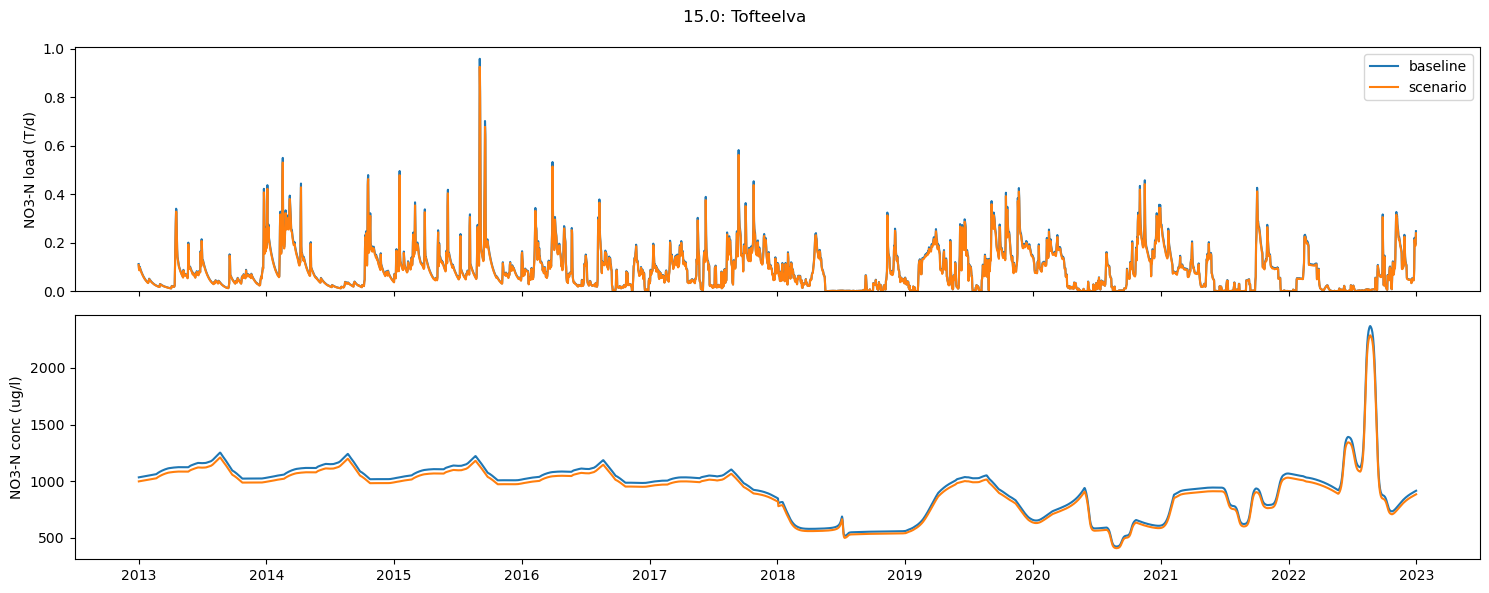

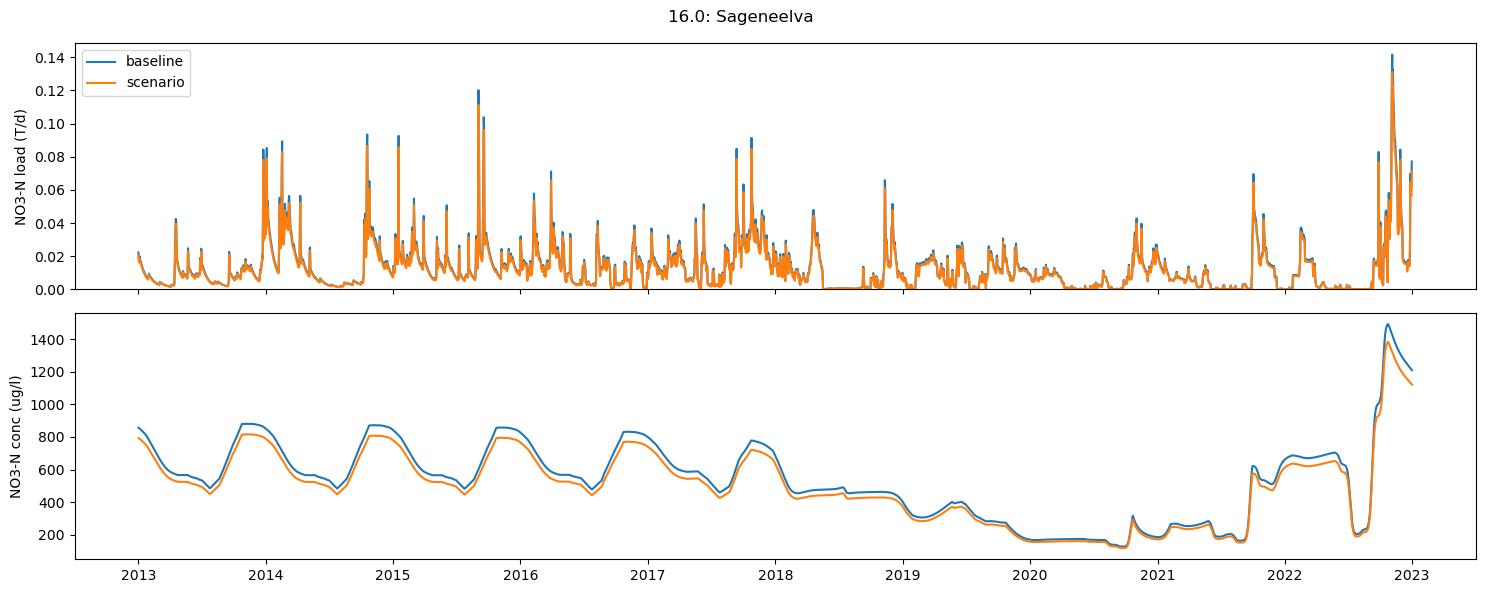

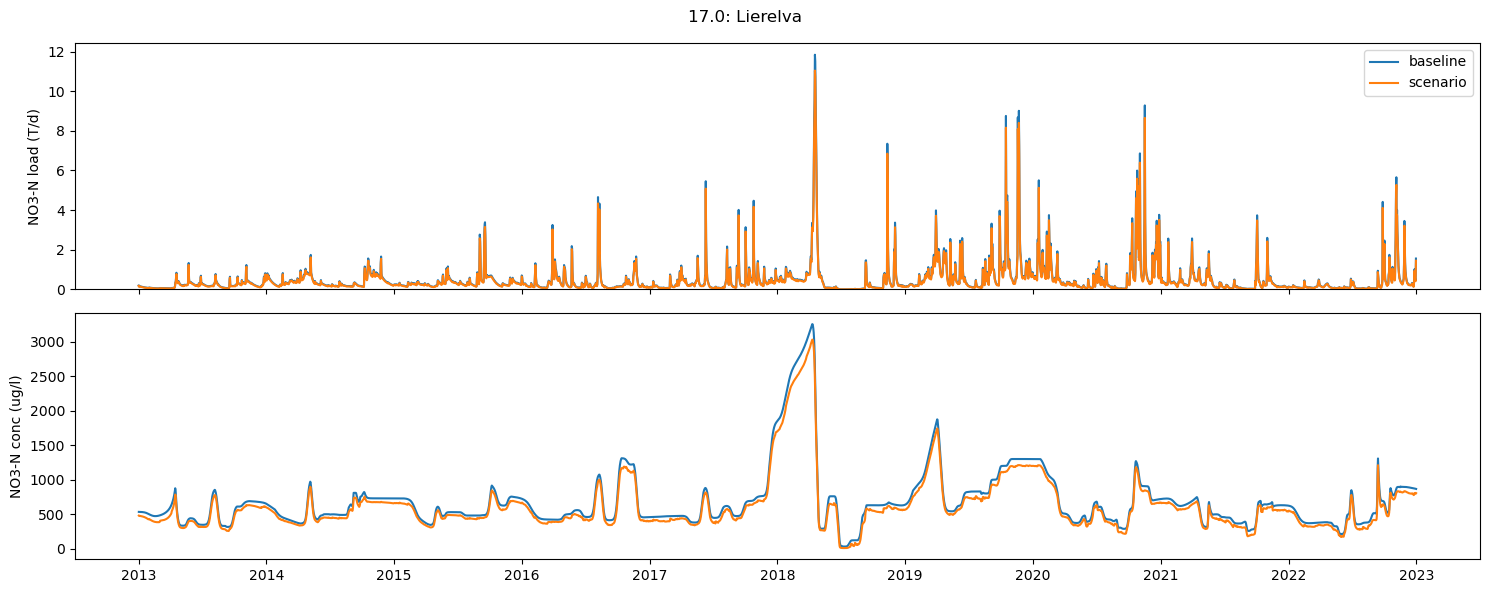

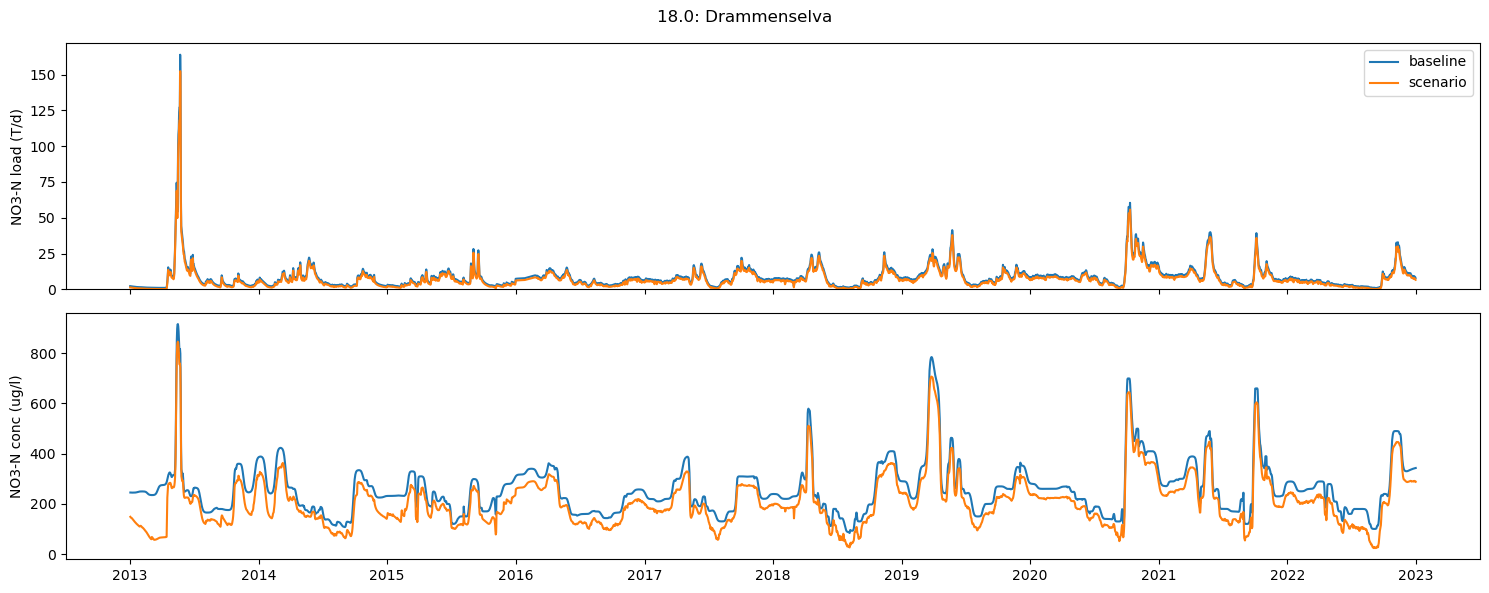

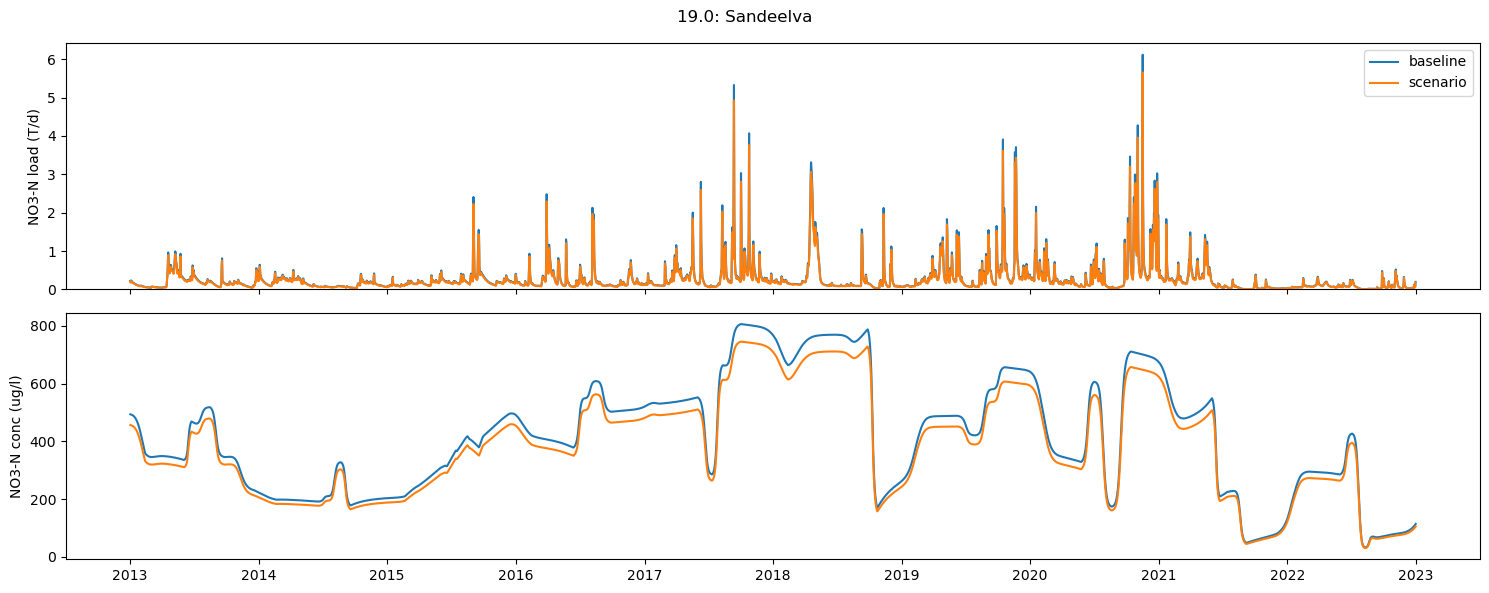

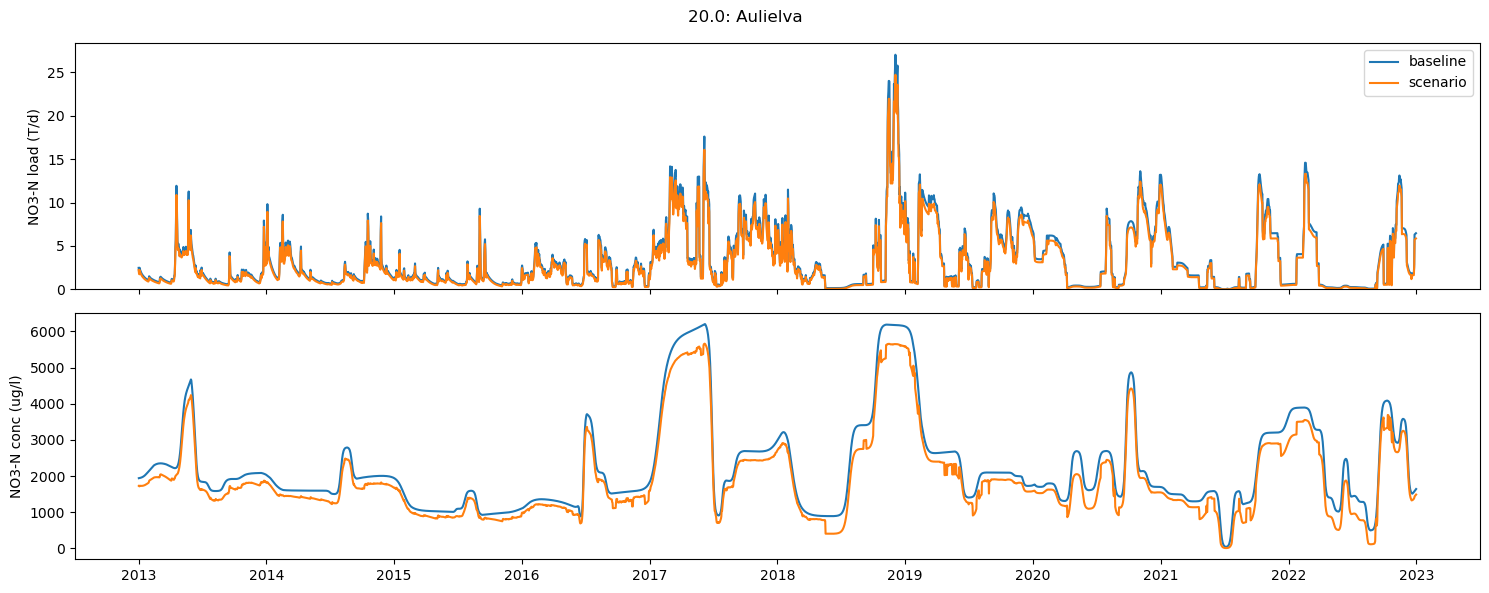

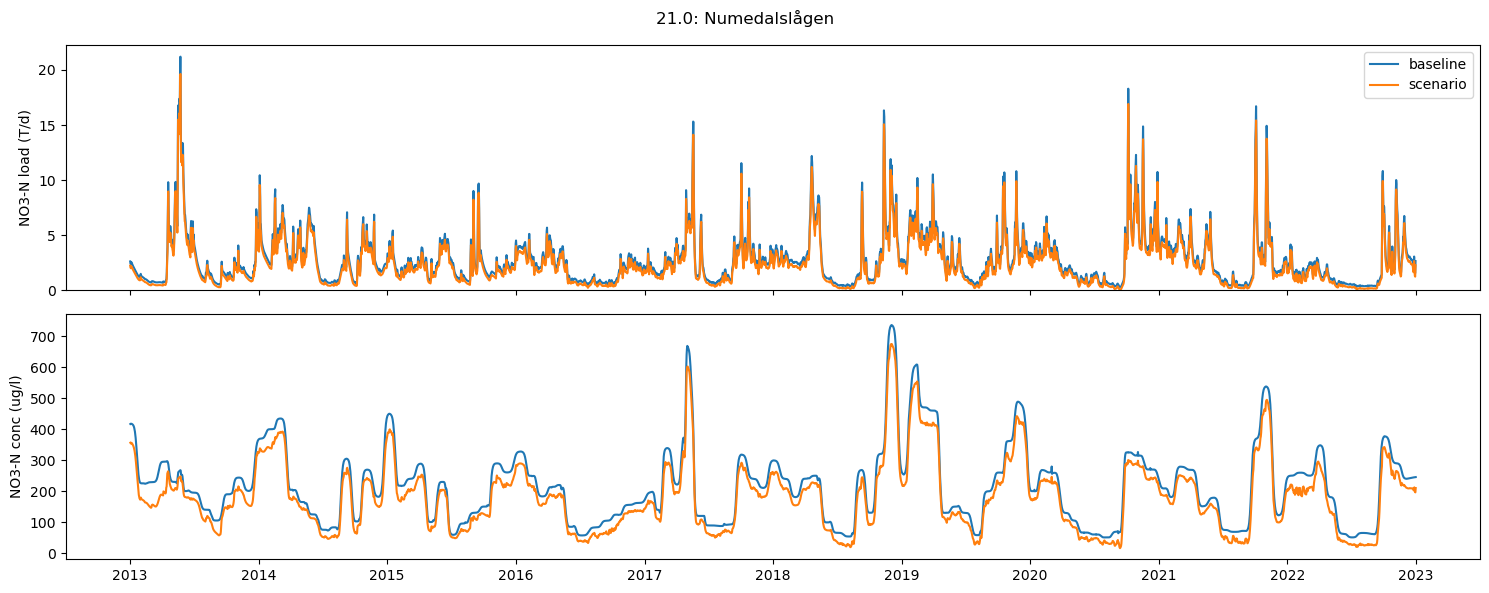

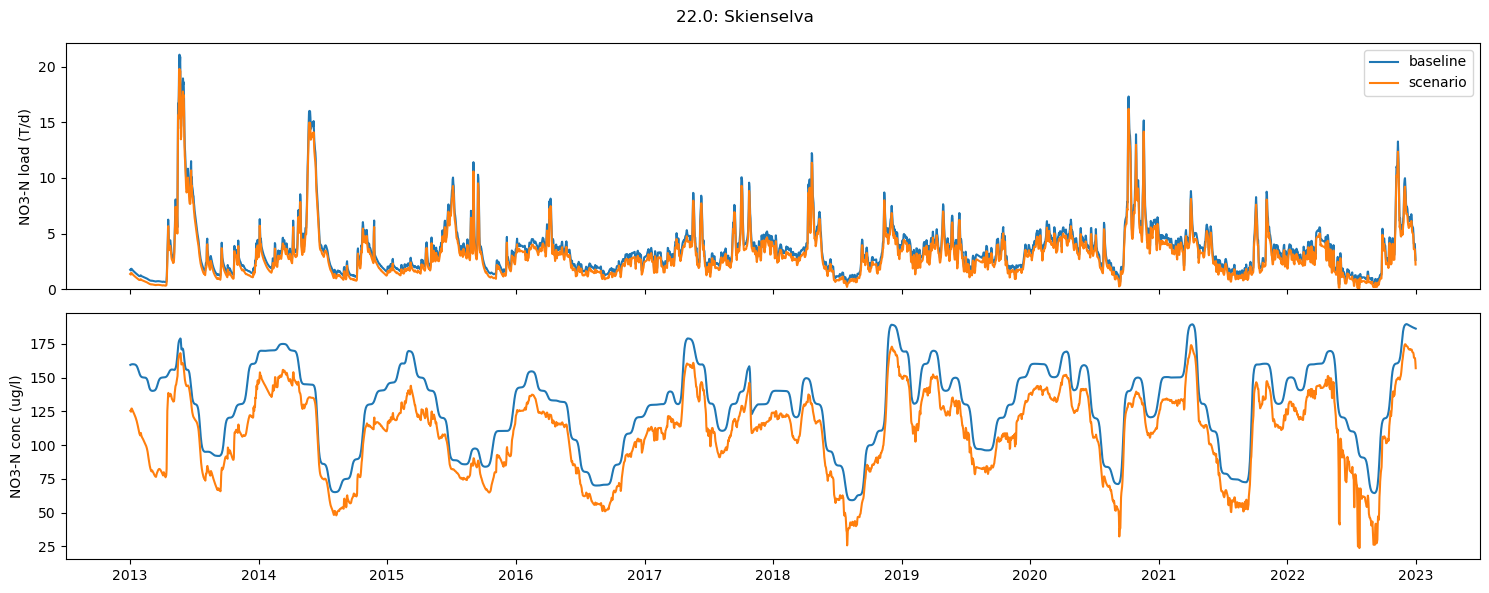

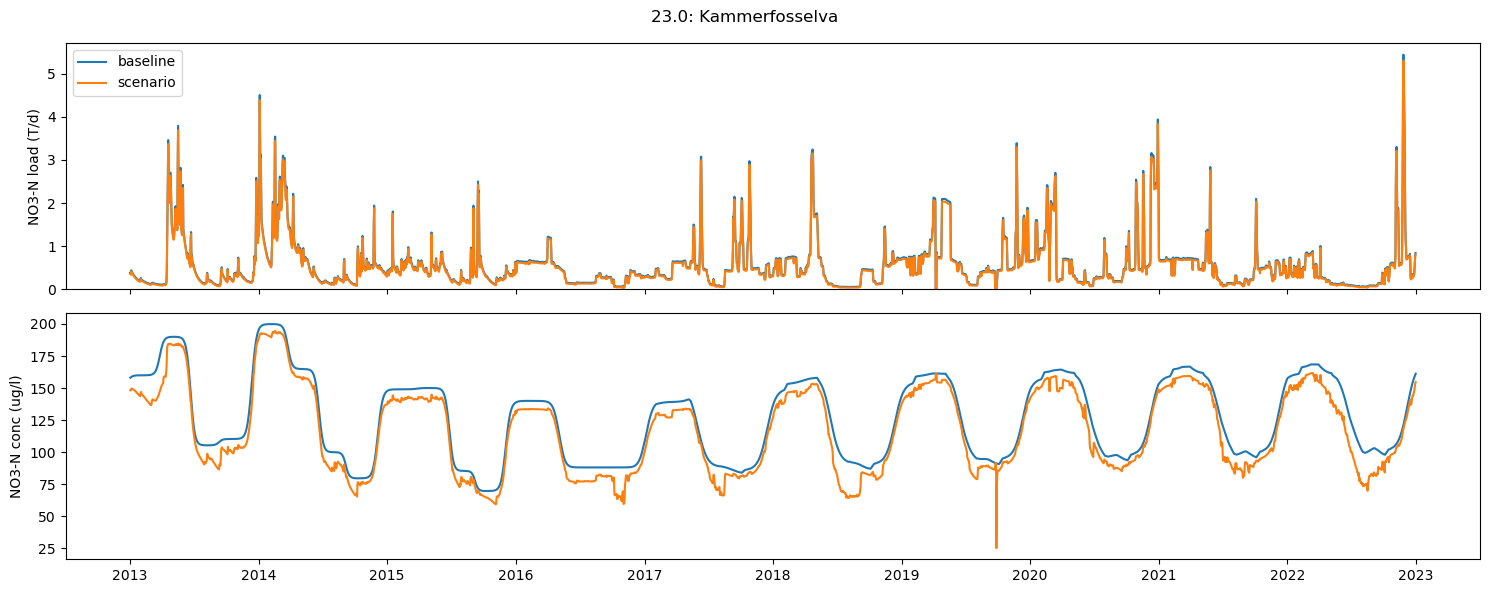

In [41]:
ds_bsl = xr.open_dataset(fpath_baseline_data)
ds_bsl = ds_bsl.sel(river_time=slice(start_date, end_date))

var = "river_NO3NO2N"

for riv_no in riv_nos:

    riv_name = river_meta_df.loc[riv_no, "river_name"]

    # Plot the baseline
    fig, axs = plt.subplots(2, 1, figsize=(15, 6), sharex=True, sharey=False)
    axs = axs.flatten()

    # Loads
    plot_bsl_load_df = daily_load_dict[riv_no][["total"]].copy() / 1000  #.loc[st_dt:end_df_dt, :] / 1000
    axs[0].plot(plot_bsl_load_df.index.values, plot_bsl_load_df["total"], label="baseline")

    # Concentrations
    plot_bsl_ds = ds_bsl.sel(real_river=riv_no)
    axs[1].plot(plot_bsl_ds["river_time"].values, plot_bsl_ds[var].values, label="baseline")

    # Plot scenarios
    for scenario in scen_setup_df.columns:

        # Get concentration data
        plot_conc_df = main_results_dict[(scenario, 'conc')][riv_no].copy()
        plot_scen_ds = ds_scen_dict[scenario].copy().sel(real_river=riv_no)

        # Get loads data
        plot_scen_load_df = (
            main_results_dict[(scenario, 'loads')][riv_no][["total"]]
            .copy() / 1000
        )

        # Plot loads
        axs[0].plot(plot_scen_load_df.index.values, plot_scen_load_df["total"], label='scenario')
        axs[0].set_ylabel("NO3-N load (T/d)")
        axs[0].set_ylim(ymin=0)

        # Plot concs
        axs[1].plot(plot_scen_ds["river_time"].values, plot_scen_ds[var].values, label='scenario')
        # axs[1].plot(plot_conc_df.index, plot_conc_df[var].values, label='df_scenario')

        # --------------------------------------------------

    # # Zoom in
    # plot_start_date = datetime.strptime(st, '%Y-%m-%d')
    # plot_end_date = datetime.strptime(end, '%Y-%m-%d')
    # axs[0].set_xlim(xmin=plot_start_date, xmax=plot_end_date)
    # axs[1].set_xlim(xmin=plot_start_date, xmax=plot_end_date)
    # axs[0].set_ylim(ymax=25)
    # # axs[1].set_ylim(ymax=300)
    # axs[0].yaxis.grid(True, which='major')
    # axs[1].yaxis.grid(True, which='major')

    # Tidy up & save
    axs[1].set_ylabel("NO3-N conc (ug/l)")
    axs[0].legend()
    plt.suptitle(f'{riv_no}: {riv_name}')
    plt.tight_layout()

    fpath = os.path.join(fig_folder, "scenario_tseries", f"scenario_ts_{riv_name}_v{v}.png")
    plt.savefig(fpath)

    plt.show()

## Comments

* Scenario concentrations can have unrealistic step changes in them. This is especially bad for Tista, where the baseline concentration is smooth enough, but the baseline load is already very steppy, so then we get very steppy scenarios. Even more so as in Tista there was a lot of redistribution of negative mass, i.e. times when the scenario reduction factor = 1, so then the concentration hops up to the baseline.

# Summary of effect of scenarios

Rough back-of-envelope estimate of % reduction is about 15% (from about 75% reduction of sewage inputs, 10% of agricultural inputs, and given 63% of inputs are agricultural, 12% are WWTW)

In [42]:
((0.63 * 0.1) + (0.12 * 0.75) + (0.25 * 0)) / (0.63 + 0.12 + 0.25)

0.153

In [48]:
multi_index_df = pd.concat([df['total'] for df in daily_load_dict.values()], keys=daily_load_dict.keys())
multi_index_df.head()

     date      
6.0  2013-01-01    4235.834311
     2013-01-02    3918.087439
     2013-01-03    1991.311006
     2013-01-04    1963.764012
     2013-01-05    1890.143944
Name: total, dtype: float64

In [50]:
def process_dict(loads_dict, input_column_name, output_col_name):
    # Concatenate dataframes with keys as the first level of the index
    # Keep only the desired column from each dataframe
    multi_index_df = pd.concat([df[input_column_name] for df in loads_dict.values()], keys=loads_dict.keys())

    # Group by the first level of the index (riv_number), resample to annual frequency, sum within each year,
    # then calculate the mean over years
    yr_sum_s = multi_index_df.groupby(level=0).resample('YE', level=1).sum()
    yr_meansum_s = yr_sum_s.groupby(level=0).mean()

    # Reset the index and rename the columns
    yr_meansum_s.name = output_col_name

    return yr_meansum_s


# Combine into one df
def combine_processed(baseline_s, scenario_s, column_name):
    # Merge the two dataframes on the index (river_number)
    result_df = pd.merge(baseline_s, scenario_s, left_index=True, right_index=True)

    total_row = result_df.sum()
    total_row.name = column_name
    result_df.loc[column_name, :] = total_row

    # Convert from kg to T and round
    result_df = (result_df / 1000).round(2)

    result_df['f'] = result_df['scenario'] / result_df['baseline']
    result_df['1-f'] = 1 - result_df['f']

    # Print the resulting dataframe
    print(result_df)
    return result_df

In [53]:
# Total load reduction for oslofjord
baseline_s = process_dict(daily_load_dict, 'total', 'baseline')
scenario_s = process_dict(scenario_loads_dict, 'total', 'scenario')
result_df = combine_processed(baseline_s, scenario_s, 'total')

       baseline  scenario         f       1-f
6.0      679.38    610.47  0.898569  0.101431
7.0     8352.01   6983.13  0.836102  0.163898
8.0      341.85    312.40  0.913851  0.086149
9.0      197.22    179.39  0.909593  0.090407
10.0     149.97    136.97  0.913316  0.086684
11.0      44.72     44.02  0.984347  0.015653
12.0      29.79     28.81  0.967103  0.032897
13.0      88.85     84.42  0.950141  0.049859
14.0     310.94    290.45  0.934103  0.065897
15.0      33.31     32.16  0.965476  0.034524
16.0       4.69      4.34  0.925373  0.074627
17.0     178.17    163.81  0.919403  0.080597
18.0    3195.96   2713.98  0.849191  0.150809
19.0     100.18     92.63  0.924636  0.075364
20.0    1212.97   1087.87  0.896865  0.103135
21.0    1026.96    883.65  0.860452  0.139548
22.0    1314.31   1146.05  0.871978  0.128022
23.0     207.44    197.13  0.950299  0.049701
total  17468.73  14991.68  0.858201  0.141799


The total load reduction for the Oslofjord is 14%, very close to the 15% expected from the back-of-the-envelope calculation. Phew! Glomma: 16% reduction; Drammenselva: 15% reduction. Rest: less, sometimes a lot less.

To do:
* Look at seasonality
* In develop_make_scenarios, look at change in sewage inputs (or separate notebook?).

In [57]:
# Agricltural load reduction for oslofjord
baseline_s = process_dict(daily_load_dict, 'agriculture', 'baseline')
scenario_s = process_dict(scenario_loads_dict, 'agriculture', 'scenario')
result_df = combine_processed(baseline_s, scenario_s, 'agriculture')

fpath = os.path.join(csv_exploration_folder, f"v{v}", "change_agricultural_loads.csv")
result_df.to_csv(fpath)

             baseline  scenario         f       1-f
6.0            429.17    386.25  0.899993  0.100007
7.0           5244.66   4720.19  0.899999  0.100001
8.0            248.15    223.34  0.900020  0.099980
9.0            156.78    141.10  0.899987  0.100013
10.0           123.64    111.27  0.899951  0.100049
11.0             6.87      6.18  0.899563  0.100437
12.0             9.77      8.80  0.900716  0.099284
13.0            40.82     36.74  0.900049  0.099951
14.0           204.82    184.34  0.900010  0.099990
15.0            11.49     10.35  0.900783  0.099217
16.0             3.46      3.11  0.898844  0.101156
17.0           116.99    105.29  0.899991  0.100009
18.0          1833.46   1650.12  0.900003  0.099997
19.0            75.56     68.00  0.899947  0.100053
20.0           974.44    876.99  0.899994  0.100006
21.0           587.85    529.07  0.900009  0.099991
22.0           541.68    487.51  0.899996  0.100004
23.0            44.90     40.41  0.900000  0.100000
agriculture 

In [58]:
# Large WWTW
# Agricltural load reduction for oslofjord
sector = 'large-wastewater'
baseline_s = process_dict(daily_load_dict, sector, 'baseline')
scenario_s = process_dict(scenario_loads_dict, sector, 'scenario')
result_df = combine_processed(baseline_s, scenario_s, sector)

fpath = os.path.join(csv_exploration_folder, f"v{v}", "change_river-wwtw_loads.csv")
result_df.to_csv(fpath)

                  baseline  scenario         f       1-f
6.0                  33.68      7.69  0.228325  0.771675
7.0                1201.07    356.66  0.296952  0.703048
8.0                   6.15      1.52  0.247154  0.752846
9.0                   2.82      0.67  0.237589  0.762411
10.0                  0.83      0.19  0.228916  0.771084
11.0                  0.02      0.01  0.500000  0.500000
12.0                  0.01      0.00  0.000000  1.000000
13.0                  0.44      0.10  0.227273  0.772727
14.0                  0.00      0.00       NaN       NaN
15.0                  0.00      0.00       NaN       NaN
16.0                  0.00      0.00       NaN       NaN
17.0                  3.54      0.87  0.245763  0.754237
18.0                391.86     93.23  0.237917  0.762083
19.0                  0.00      0.00       NaN       NaN
20.0                 35.94      8.28  0.230384  0.769616
21.0                110.37     25.83  0.234031  0.765969
22.0                153.26     